# **Active Object Localization with Deep Reinforcement Learning**

In [20]:
!git clone https://github.com/SkalskiP/yolov9.git

Cloning into 'yolov9'...


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import sys
import math
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml

from yolov9.models.yolo import Model
from yolov9.utils.augmentations import letterbox

%matplotlib inline

E:\Studies\Sem-8\REL301m\project\Object-Detection-Deep-Reinforcement-Learning\Dynamic\DQN_4layer_yolov9_backbone\yolov9\utils\general.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


**Prepare and loading images from dataset along with their bounding boxes:**

In [2]:
def load_data_from_csv(df_path, target_size=(224, 224)):
    final_image_list = []
    final_bbox_list = []

    df = pd.read_csv(df_path)
    len = df.shape[0]
    n_img = 0

    for _, row in df.iterrows():
        img_path = row['img_path']
        x_min = int(row['x_min'])
        x_max = int(row['x_max'])
        y_min = int(row['y_min'])
        y_max = int(row['y_max'])

        # read img
        img_path = img_path.replace('\\', '/')
        img_path = r'../' + img_path
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB

        # get original size
        h_orig, w_orig, _ = image.shape

        # resize img
        image = cv2.resize(image, target_size)

        # scale bounding box coordinates
        x_scale = target_size[0] / w_orig
        y_scale = target_size[1] / h_orig

        x_min = int(x_min * x_scale)
        x_max = int(x_max * x_scale)
        y_min = int(y_min * y_scale)
        y_max = int(y_max * y_scale)

        final_image_list.append(image)
        final_bbox_list.append([x_min, y_min, x_max, y_max])
        n_img+=1
        print(f'{n_img}/{len}')

        #Convert to NumPy arrays after the loop finishes
    image_array = np.asarray(final_image_list, dtype=np.uint8)
    bbox_array = np.asarray(final_bbox_list)

    return image_array, bbox_array

**Load dataset**

In [3]:
dataset_csv_path = '../img_path_with_bbox.csv'
data = load_data_from_csv(df_path=dataset_csv_path, target_size=(640, 640))
image_list, bbox_list = data
print(f"Loaded {len(image_list)} images and {len(bbox_list)} bounding boxes")

1/1117
2/1117
3/1117
4/1117
5/1117
6/1117
7/1117
8/1117
9/1117
10/1117
11/1117
12/1117
13/1117
14/1117
15/1117
16/1117
17/1117
18/1117
19/1117
20/1117
21/1117
22/1117
23/1117
24/1117
25/1117
26/1117
27/1117
28/1117
29/1117
30/1117
31/1117
32/1117
33/1117
34/1117
35/1117
36/1117
37/1117
38/1117
39/1117
40/1117
41/1117
42/1117
43/1117
44/1117
45/1117
46/1117
47/1117
48/1117
49/1117
50/1117
51/1117
52/1117
53/1117
54/1117
55/1117
56/1117
57/1117
58/1117
59/1117
60/1117
61/1117
62/1117
63/1117
64/1117
65/1117
66/1117
67/1117
68/1117
69/1117
70/1117
71/1117
72/1117
73/1117
74/1117
75/1117
76/1117
77/1117
78/1117
79/1117
80/1117
81/1117
82/1117
83/1117
84/1117
85/1117
86/1117
87/1117
88/1117
89/1117
90/1117
91/1117
92/1117
93/1117
94/1117
95/1117
96/1117
97/1117
98/1117
99/1117
100/1117
101/1117
102/1117
103/1117
104/1117
105/1117
106/1117
107/1117
108/1117
109/1117
110/1117
111/1117
112/1117
113/1117
114/1117
115/1117
116/1117
117/1117
118/1117
119/1117
120/1117
121/1117
122/1117
123/1117
1

**Showing some pictures from 20 classes of dataset:**

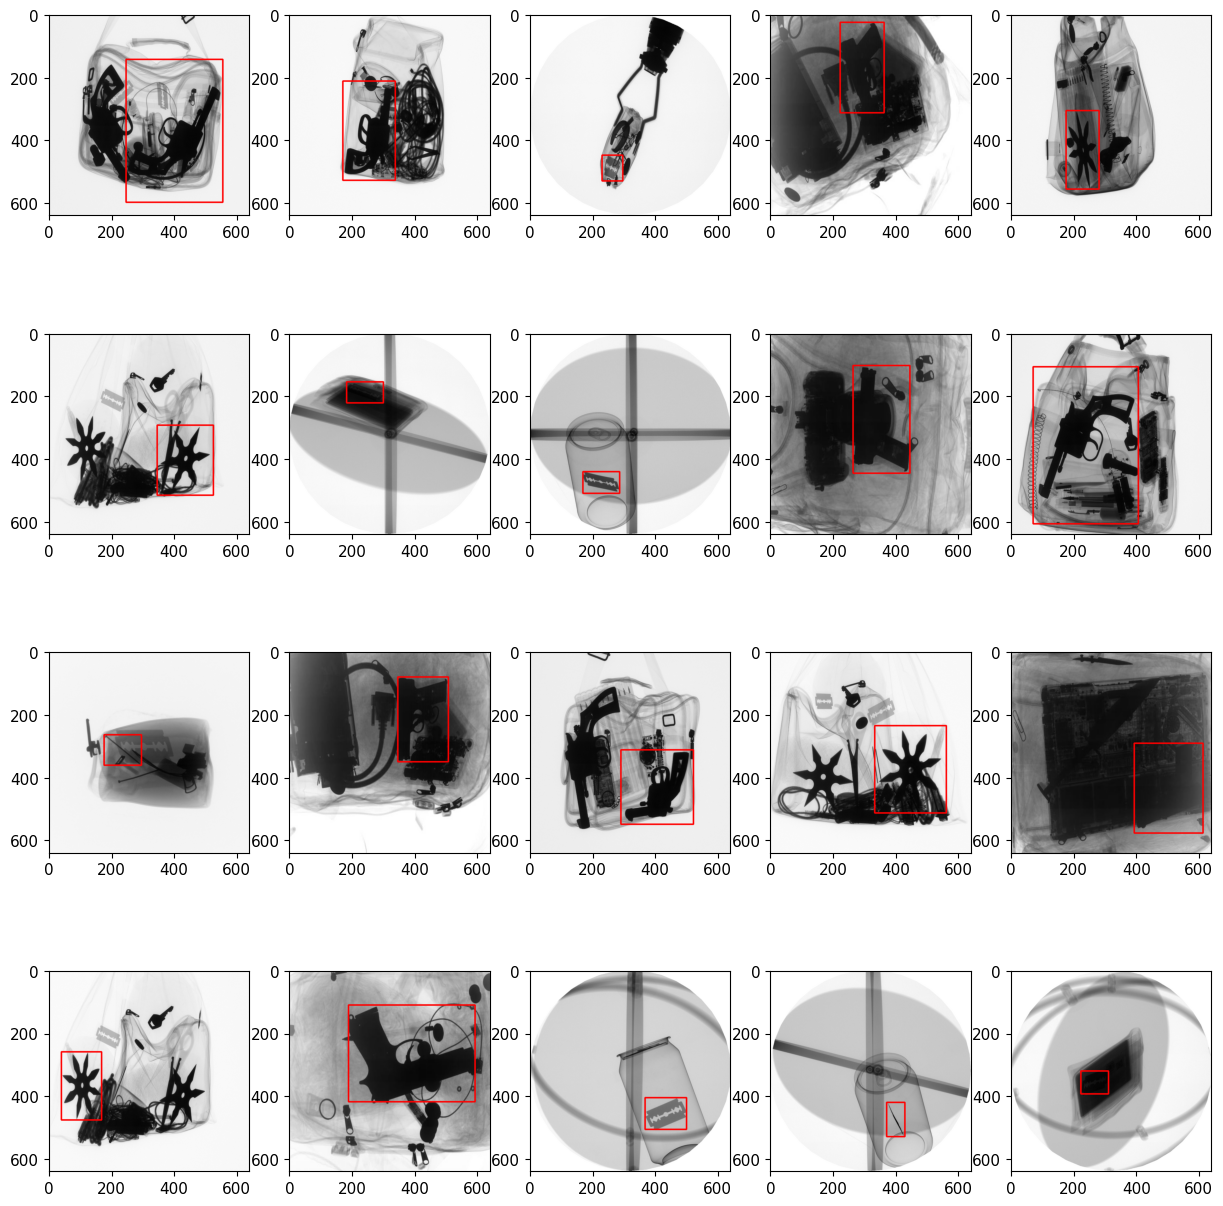

In [6]:
shuffled_indices = np.random.permutation(len(image_list))[:20]
shuffled_images = [image_list[i] for i in shuffled_indices]
shuffled_bboxes = [bbox_list[i] for i in shuffled_indices]

plt.figure(figsize=(15,20))
from_start, to_start = 0, 20
for i in range(from_start, to_start):
    plt.subplot(5,5,i-from_start+1)
    # im = image_list[i]
    # bbox = bbox_list[i]
    im = shuffled_images[i-from_start]
    bbox = shuffled_bboxes[i-from_start]
    # Draw a rectangle with blue line borders of thickness of 1 px
    mask = cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3])  , (255, 0, 0) , 3)
    masked_data = cv2.bitwise_and(im, im, mask)
    plt.imshow(masked_data)
plt.show()

**Train test split data**

In [4]:
from sklearn.model_selection import train_test_split

# First split: 80% for training, 20% for temporary (validation + test)
train_images, temp_images, train_bboxes, temp_bboxes = train_test_split(
    image_list, bbox_list, test_size=0.2, random_state=42
)

# Second split: Split the temporary set into validation and test sets (50% of temp -> 10% of total for each)
val_images, test_images, val_bboxes, test_bboxes = train_test_split(
    temp_images, temp_bboxes, test_size=0.5, random_state=42
)

print(f"Total images: {len(image_list)}")
print(f"Training set size: {len(train_images)} images")
print(f"Validation set size: {len(val_images)} images")
print(f"Testing set size: {len(test_images)} images")

Total images: 1117
Training set size: 893 images
Validation set size: 112 images
Testing set size: 112 images


**Training the agent:**
(to see the images of test results scroll down in the output box)

In [2]:
history_size = 1
# history_size = 5
action_option = 9
# max_steps = 20 # max steps
max_steps = 20 # max steps
experience_sample_size = 20 # batch size
max_experience_size = 1000 # replay buffer size
gamma = 0.5
# gamma = 0.1
loss_arr = []

# --- Epsilon-Greedy Strategy Parameters ---
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay_epochs = 80 # Number of epochs to decay epsilon over

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from collections import deque

# --- PyTorch Model Definition ---
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        # self.fc3 = nn.Linear(1024, output_size)
        # add another layer
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # x = self.fc3(x)

        # with additional layer
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def create_q_model():
    feature_size = 512  # YOLOv9 backbone feature size
    input_size = feature_size + action_option * history_size
    output_size = action_option
    return QNetwork(input_size, output_size)

def create_feature_extractor(finetune: bool = False):
    """Create a YOLOv9 backbone feature extractor pre-trained on GDXray."""
    config_path = r'yolov9/models/detect/gelan-c.yaml'
    weights_path = r'weights/best.pt'
    
    # Load config
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Create full model
    model = Model(config, ch=3, nc=4)
    
    # Load weights
    if weights_path and os.path.exists(weights_path):
        ckpt = torch.load(weights_path, map_location="cpu", weights_only=False)
        model.load_state_dict(ckpt["model"].float().state_dict(), strict=False)
        print(f"Loaded YOLOv9 weights from {weights_path}")
    
    # Extract backbone
    feature_extractor = nn.Sequential(*model.model[:9])
    
    if finetune:
        for param in feature_extractor.parameters():
            param.requires_grad = True
        feature_extractor.train()
    else:
        for param in feature_extractor.parameters():
            param.requires_grad = False
        feature_extractor.eval()
    
    return feature_extractor

# --- PyTorch Feature Extraction ---
def extract_feature(image, history, feature_model):
    # 1. History feature (one-hot encoding of action history)
    history_feature = np.zeros(action_option * history_size, dtype=np.float32)
    for i in range(history_size):
        action = history[i]
        if action != -1:
            history_feature[i * action_option + action] = 1.0

    # 2. Image feature (YOLOv9 preprocessing dùng letterbox 640x640, chuẩn hóa, CHW)
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.ndim == 3 and image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)

    img_rgb = image.copy()
    img_letterbox, _, _ = letterbox(
        img_rgb,
        new_shape=(640, 640),
        auto=False,
        scaleFill=False,
        scaleup=False
    )

    img_letterbox = img_letterbox.astype(np.float32) / 255.0
    img_letterbox = np.ascontiguousarray(img_letterbox.transpose(2, 0, 1))
    input_tensor = torch.from_numpy(img_letterbox).unsqueeze(0).to(device)
    
    requires_grad = feature_model.training and any(param.requires_grad for param in feature_model.parameters())
    with torch.set_grad_enabled(requires_grad):
        feats = feature_model(input_tensor)
    
    pool = nn.AdaptiveAvgPool2d((1, 1))
    feats = pool(feats)
    feats = feats.view(feats.size(0), -1)

    image_feature = feats.detach().cpu().numpy().flatten().astype(np.float32)

    feature = np.concatenate((image_feature, history_feature))
    return feature[np.newaxis, :]

def compute_q(feature, deep_q_model):
    feature_tensor = torch.from_numpy(feature).float().to(device)
    with torch.no_grad():
        output = deep_q_model(feature_tensor)
    return output.cpu().numpy().flatten()


def compute_mask(action, current_mask):
    image_rate = 0.1
    delta_width = image_rate * (current_mask[2] - current_mask[0])
    delta_height = image_rate * (current_mask[3] - current_mask[1])
    dx1 = 0
    dy1 = 0
    dx2 = 0
    dy2 = 0

    if action == 0:
        dx1 = delta_width
        dx2 = delta_width
    elif action == 1:
        dx1 = -delta_width
        dx2 = -delta_width
    elif action == 2:
        dy1 = delta_height
        dy2 = delta_height
    elif action == 3:
        dy1 = -delta_height
        dy2 = -delta_height
    elif action == 4:
        dx1 = -delta_width
        dx2 = delta_width
        dy1 = -delta_height
        dy2 = delta_height
    elif action == 5:
        dx1 = delta_width
        dx2 = -delta_width
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 6:
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 7:
        dx1 = delta_width
        dx2 = -delta_width

    new_mask_tmp = np.array([current_mask[0] + dx1, current_mask[1] + dy1,
                         current_mask[2] + dx2, current_mask[3] + dy2])
    new_mask = np.array([
        min(new_mask_tmp[0], new_mask_tmp[2]),
        min(new_mask_tmp[1], new_mask_tmp[3]),
        max(new_mask_tmp[0], new_mask_tmp[2]),
        max(new_mask_tmp[1], new_mask_tmp[3])
    ])

    return new_mask


def compute_iou(mask, ground_truth):
    dx = min(mask[2], ground_truth[2]) - max(mask[0], ground_truth[0])
    dy = min(mask[3], ground_truth[3]) - max(mask[1], ground_truth[1])

    if (dx >= 0) and (dy >= 0):
        inter_area = dx * dy
    else:
        inter_area = 0

    mask_area = (mask[2] - mask[0]) * (mask[3] - mask[1])
    ground_truth_area = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])

    return inter_area / (mask_area + ground_truth_area - inter_area + 1e-8)


def compute_reward(action, ground_truth, current_mask):
    new_mask = compute_mask(action, current_mask)
    iou_new = compute_iou(new_mask, ground_truth)
    iou_current = compute_iou(current_mask, ground_truth)

    # area_current = (current_mask[2] - current_mask[0]) * (current_mask[3] - current_mask[1])
    # area_gt = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])
    # oversize = max(area_current - area_gt, 0.0)
    # penalty = 0.01 * oversize / (area_gt + 1e-8)  # scale so it stays small
    # reward = (iou_new - iou_current) * 10

    if iou_new > iou_current:
        reward = 1
    else:
        reward = -1

    return reward


def compute_end_reward(current_mask, ground_truth):
    current_iou = compute_iou(current_mask, ground_truth)
    # if current_iou > 0.5:
    #     return 10
    # elif current_iou > 0.2:
    #     return -5
    # else:
    #     return -2

    if current_iou > 0.5:
    # if current_iou > 0.7:
        return 3
    else:
        return -3


def select_action(ground_truth_box, step, q_value, epsilon, current_mask):
    if step == max_steps:
        action = 8
    else:
        if random.random() > epsilon:
            action = np.argmax(q_value)
        else:
            end_reward = compute_end_reward(current_mask, ground_truth_box)
            if end_reward > 0:
                action = 8
            else:
                rewards = []
                for i in range(action_option - 1):
                    reward = compute_reward(i, ground_truth_box, current_mask)
                    rewards.append(reward)
                rewards = np.asarray(rewards)
                positive_reward_index = np.where(rewards >= 0)[0]

                if len(positive_reward_index) == 0:
                    positive_reward_index = np.asarray(range(action_option))

                action = np.random.choice(positive_reward_index)

    return action


def execute_action(action, history, ground_truth_box, current_mask):
    if action == 8:
        new_mask = current_mask
        reward = compute_end_reward(current_mask, ground_truth_box)
        end = True
    else:
        new_mask = compute_mask(action, current_mask)
        reward = compute_reward(action, ground_truth_box, current_mask)
        history = history[1:]
        history.append(action)
        end = False

    return new_mask, reward, end, history


def compute_target(reward, new_feature, model):
    with torch.no_grad():
        q_values = model(torch.from_numpy(new_feature).float().to(device))
    return reward + gamma * torch.max(q_values).item()


def crop_image(image, new_mask):
    height, width, channel = np.shape(image)
    new_mask = np.asarray(new_mask).astype("int")
    new_mask[0] = max(new_mask[0], 0)
    new_mask[1] = max(new_mask[1], 0)
    new_mask[2] = min(new_mask[2], width)
    new_mask[3] = min(new_mask[3], height)
    cropped_image = image[new_mask[1]:new_mask[3], new_mask[0]:new_mask[2]]
    new_height, new_width, new_channel = np.shape(cropped_image)

    if new_height == 0 or new_width == 0:
        return np.zeros((512, 512, 3), dtype=np.uint8)
    else:
        return cropped_image


def experience_replay(policy_net, target_net, feature_model, experience, optimizer, loss_fn):
    if len(experience) < experience_sample_size:
        return

    sample = random.sample(experience, experience_sample_size)
    features, actions, new_features, rewards, ends = zip(*sample)

    feature_batch = torch.from_numpy(np.concatenate(features, axis=0)).float().to(device)
    action_batch = torch.tensor(actions, dtype=torch.int64).to(device)
    new_feature_batch = torch.from_numpy(np.concatenate(new_features, axis=0)).float().to(device)
    reward_batch = torch.tensor(rewards, dtype=torch.float32).to(device)
    end_batch = torch.tensor(ends, dtype=torch.float32).to(device)

    current_q_values = policy_net(feature_batch)
    current_q_values = current_q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_net(new_feature_batch).max(1)[0].detach()

    target_q_values = reward_batch + (1 - end_batch) * gamma * next_q_values

    loss = loss_fn(current_q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    params_to_clip = list(policy_net.parameters()) + [p for p in feature_model.parameters() if p.requires_grad]
    if params_to_clip:
        torch.nn.utils.clip_grad_norm_(params_to_clip, 1.0)
    optimizer.step()

    global loss_arr

    loss_arr.append(loss.item())
    if len(loss_arr) == 100:
        avg_loss = sum(loss_arr) / len(loss_arr)
        print("loss %s" % str(avg_loss))

        if os.path.exists(r'train_plot_yolov9') is False:
            os.makedirs(r'train_plot_yolov9')

        loss_csv_path = r"train_plot_yolov9/loss.csv"

        write_header = not os.path.exists(loss_csv_path) or os.path.getsize(loss_csv_path) == 0
        with open(loss_csv_path, 'a') as f:
            if write_header:
                f.write('loss\n')
            f.write(f"{avg_loss}\n")

        loss_arr = []


# def validate_model(target_net, feature_model, val_images, val_bboxes):
#     """Evaluates the model on the validation set and returns the average IoU."""
#     print("--- Running Validation ---")

#     iou_scores = []

#     target_net.eval()
#     feature_model.eval()

#     with torch.no_grad():
#         for i in range(len(val_images)):
#             image = val_images[i]
#             ground_truth_box = val_bboxes[i]

#             history = [-1] * history_size
#             height, width, _ = image.shape
#             current_mask = np.asarray([0, 0, width, height])

#             end = False
#             step = 0

#             while not end:
#                 feature = extract_feature(image, history, feature_model)
#                 q_value = compute_q(feature, target_net)
#                 action = np.argmax(q_value)

#                 history = history[1:]
#                 history.append(action)

#                 if action == 8 or step == max_steps:
#                     end = True
#                 else:
#                     current_mask = compute_mask(action, current_mask)

#                 step += 1

#             final_iou = compute_iou(current_mask, ground_truth_box)
#             iou_scores.append(final_iou)

#     avg_iou = np.mean(iou_scores)
#     print(f"--- Validation Complete. Average IoU: {avg_iou:.4f} ---")

#     return avg_iou

def validate_model(val_images, val_bboxes):
    iou = []

    number_of_image = len(val_images)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_model = create_feature_extractor(finetune=False).to(device)
    deep_q = create_q_model().to(device)

    deep_q_checkpoint = torch.load(r"weights_DQN_4layer_yolov9/latest_model.pth", map_location=device)
    deep_q.load_state_dict(deep_q_checkpoint['policy_net_state_dict'])
    
    # yolov9_backbone_path = r'weights\best.pt'
    # feature_state_dict = torch.load(yolov9_backbone_path, map_location=device, weights_only=False)
    # feature_model.load_state_dict(feature_state_dict, strict=False)

    deep_q.eval()
    feature_model.eval()

    print("--- Running Validation ---")

    for i in range(0, number_of_image):
        bounding_box = val_bboxes[i]
        image = val_images[i].copy()
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, feature_model)
        
        end = False
        masks = []
        step = 0

        while not end:
            q_value = compute_q(feature, deep_q)
            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == max_steps:
                end = True
                new_mask = current_mask
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, feature_model)
            
            masks.append(new_mask)
            current_mask = new_mask
            step += 1

        mask = masks[-1] if masks else current_mask
        iou.append(compute_iou(mask, bounding_box))

    avg_iou = sum(iou) / len(iou)
    print(f"--- Validation Complete. Average IoU: {avg_iou:.4f} ---")
    
    return avg_iou


def plot_loss_curve(df_iou_path=r"train_plot_yolov9/loss.csv"):
    df_loss = pd.read_csv(df_iou_path)
    plt.figure(figsize=(10, 5))

    # plot loss curve (have only 'loss' column)
    plt.plot(df_loss.index, df_loss['loss'], label='Training Loss', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.savefig(r'train_plot_yolov9/loss.png')
    plt.close()
    

def plot_iou_curve(df_iou_path=r"train_plot_yolov9/avg_iou.csv"):
    plt.figure(figsize=(10, 5))
    df_iou = pd.read_csv(df_iou_path)
    plt.plot(df_iou['epoch'], df_iou['avg_iou'], label='Validation Average IoU', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Average IoU')
    plt.title('Validation Average IoU Curve')
    plt.legend()
    plt.grid()
    plt.savefig(r'train_plot_yolov9/avg_iou.png')
    plt.close()


def train_deep_q(learning_rate, training_epoch, train_image_list, train_bounding_box_list, val_image_list, val_bboxes, feature_model):
    experience = deque(maxlen=max_experience_size)

    policy_net = create_q_model().to(device)
    target_net = create_q_model().to(device)

    params_to_update = list(policy_net.parameters()) + [p for p in feature_model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=4, factor=0.7, min_lr=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    latest_model_path = r"weights_DQN_4layer_yolov9/latest_model.pth"

    start_epoch = 1
    best_val_iou = -1.0

    if os.path.exists(latest_model_path):
        print(f"Resuming training from {latest_model_path}")
        checkpoint = torch.load(latest_model_path, map_location=device)
        policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        # feature_key = 'feature_extractor_state_dict' if 'feature_extractor_state_dict' in checkpoint else 'vgg16_state_dict'
        # feature_model.load_state_dict(checkpoint[feature_key])
        if 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        if 'epoch' in checkpoint:
            start_epoch =  checkpoint['epoch'] + 1

    # feature_model_path = r'weights\best.pt'
    # if os.path.exists(feature_model_path):
    #     print(f"Loading feature extractor weights from {feature_model_path}")
    #     ckpt = torch.load(feature_model_path, map_location=device, weights_only=False)
    #     missing, unexpected = feature_model.load_state_dict(
    #         ckpt["model"].float().state_dict(), strict=False)
    #     print("Missing:", missing, "Unexpected:", unexpected)

    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    loss_fn = nn.SmoothL1Loss()

    epsilon_decay_value = (epsilon_start - epsilon_final) / epsilon_decay_epochs
    epsilon = epsilon_start

    iou_csv_path = r"train_plot_yolov9/avg_iou.csv"
    if os.path.exists(r"weights_DQN_4layer_yolov9/best_model.pth") and os.path.exists(iou_csv_path):
        try:
            avg_iou_df = pd.read_csv(iou_csv_path)
            if not avg_iou_df.empty and 'avg_iou' in avg_iou_df.columns:
                best_val_iou = avg_iou_df['avg_iou'].max()
        except (pd.errors.EmptyDataError, KeyError):
            best_val_iou = -1.0

    if start_epoch > 1:
        epsilon -= epsilon_decay_value * (start_epoch - 1)
        epsilon = max(epsilon_final, epsilon)
        print(f"Adjusted epsilon for resumed training: {epsilon:.4f}")

    os.makedirs('train_plot_yolov9', exist_ok=True)

    for current_epoch in range(start_epoch, start_epoch + training_epoch):
        print(f"Now starting epoch {current_epoch} with epsilon = {epsilon:.4f}")

        policy_net.train()
        # feature_model.train()

        indices = np.random.permutation(len(train_image_list))
        training_set_size = len(indices)

        for i, idx in enumerate(indices):
            image = train_image_list[idx]
            ground_truth_box = train_bounding_box_list[idx]
            history = [-1] * history_size
            height, width, channel = np.shape(image)
            current_mask = np.asarray([0, 0, width, height])
            feature = extract_feature(image, history, feature_model)
            end = False
            step = 0
            total_reward = 0

            while not end:
                q_value = compute_q(feature, policy_net)
                action = select_action(ground_truth_box, step, q_value, epsilon, current_mask)
                new_mask, reward, end, history = execute_action(action, history, ground_truth_box, current_mask)
                cropped_image = crop_image(image, new_mask)
                new_feature = extract_feature(cropped_image, history, feature_model)

                experience.append((feature, action, new_feature, reward, end))

                experience_replay(policy_net, target_net, feature_model, experience, optimizer, loss_fn)

                feature = new_feature
                current_mask = new_mask
                step += 1
                total_reward += reward

            if (i + 1) % 100 == 0:
                print(f"  Image {i+1}/{training_set_size}, total reward {total_reward}")

        os.makedirs('weights_DQN_4layer_yolov9', exist_ok=True)
        torch.save({
            'epoch': current_epoch,
            'policy_net_state_dict': policy_net.state_dict(),
            'feature_extractor_state_dict': feature_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, latest_model_path)

        print(f"--- End of Epoch {current_epoch}: Updating target network ---")
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()

        val_iou = validate_model(val_image_list, val_bboxes)
        
        plot_loss_curve()

        # lr_before = optimizer.param_groups[0]['lr']
        # scheduler.step(val_iou)
        # lr_after = optimizer.param_groups[0]['lr']
        # if lr_after < lr_before:
        #     print(f"Epoch {current_epoch}: Learning rate reduced from {lr_before} to {lr_after}.")
        lr_before = optimizer.param_groups[0]['lr']
        scheduler.step()
        lr_after = optimizer.param_groups[0]['lr']
        print(f"Epoch {current_epoch}: Learning rate adjusted from {lr_before} to {lr_after}.")

        write_header = not os.path.exists(iou_csv_path) or os.path.getsize(iou_csv_path) == 0
        with open(iou_csv_path, 'a') as f:
            if write_header:
                f.write('epoch,avg_iou\n')
            f.write(f"{current_epoch},{val_iou}\n")

        plot_iou_curve()

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            print(f"New best validation IoU: {best_val_iou:.4f}. Saving best_model.pth")
            torch.save({
                'epoch': current_epoch,
                'policy_net_state_dict': policy_net.state_dict(),
                'feature_extractor_state_dict': feature_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, r"weights_DQN_4layer_yolov9/best_model.pth")

        if current_epoch < epsilon_decay_epochs:
            epsilon -= epsilon_decay_value
            epsilon = max(epsilon_final, epsilon)

    return policy_net, feature_model


def main():
    learning_rate = 1e-5
    training_epoch = 100

    feature_model = create_feature_extractor(finetune=False).to(device)

    trained_policy_net, trained_feature_model = train_deep_q(
        learning_rate,
        training_epoch,
        train_images,
        train_bboxes,
        val_images,
        val_bboxes,
        feature_model
    )

    os.makedirs('weights_DQN_4layer_yolov9', exist_ok=True)
    torch.save({
        'policy_net_state_dict': trained_policy_net.state_dict(),
        'feature_extractor_state_dict': trained_feature_model.state_dict(),
    }, r"weights_DQN_4layer_yolov9/final_model.pth")

Using device: cuda


In [7]:
main()

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Loaded YOLOv9 weights from weights/best.pt
Now starting epoch 1 with epsilon = 1.0000
loss 0.5671482583880425
loss 0.32011986210942267
loss 0.2517341756541282
loss 0.2076639648177661
loss 0.18500955225201324
loss 0.16147398234461435
loss 0.14319337469991297
loss 0.13942591696279125
loss 0.1740591675322503
loss 0.14426042879582382
loss 0.1343474770197645
loss 0.12758506170706824
loss 0.15618932842393407
  Image 100/893, total reward 18
loss 0.13791710513993166
loss 0.14754970662179404
loss 0.1291927613050211
loss 0.16186726436484605
loss 0.19477592665003612
loss 0.18248111401218922
loss 0.19809309808537365
loss 0.2051841314556077
loss 0.19330072856508196
loss 0.2144521497306414
loss 0.2082865744829178
loss 0.2335390504123643
loss 0.22653875302057713
loss 0.1975106084579602
  Image 200/893, total reward 13
loss 0.18864138405770065
loss 0.15379041354637593
loss 0.1614575840299949
loss 0.19468419136013837
loss 0.1677837472385727
loss 0.1586883017537184
loss 0.16708286058506927
loss 0.15653

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 1: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.0964 ---
Epoch 1: Learning rate adjusted from 1e-05 to 9.779754323328192e-06.
New best validation IoU: 0.0964. Saving best_model.pth
Now starting epoch 2 with epsilon = 0.9888
loss 0.23695580274797975
loss 0.1796542380005121
loss 0.14541173326782883
loss 0.14434131526388227
loss 0.14353843783028425
loss 0.13736693115904927
loss 0.17057755229063332
loss 0.15774361515417695
loss 0.13701288837008177
loss 0.15190030395053328
loss 0.127443824140355
loss 0.12028857770375907
loss 0.14157840060070156
  Image 100/893, total reward 18
loss 0.11473103867843747
loss 0.11286189143545926
loss 0.12075915174558759
loss 0.09864502871409059
loss 0.11389445020351559
loss 0.11451105485670268
loss 0.12308753696270287
loss 0.12731927777640523
loss 0.1191478471737355
loss 0.12759342070668936
loss 0.1600784649141133
loss 0.12683585450053214
loss 0.1592721449676901
loss 0.1791422019060701
  Image 200/8

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 2: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1666 ---
Epoch 2: Learning rate adjusted from 9.779754323328192e-06 to 9.140576474687263e-06.
New best validation IoU: 0.1666. Saving best_model.pth
Now starting epoch 3 with epsilon = 0.9775
loss 0.103103545489721
loss 0.1151186953112483
loss 0.10019713081419468
loss 0.10895584823098034
loss 0.09880106350407004
loss 0.10700775689678267
loss 0.1116913439705968
loss 0.11629776052664965
loss 0.12764978100080043
loss 0.12050464670639485
loss 0.13824328953400256
loss 0.17036687273997814
loss 0.18195148264523595
loss 0.1617728277761489
  Image 100/893, total reward 7
loss 0.15029939073137938
loss 0.1622714088158682
loss 0.1600872400170192
loss 0.1643849248532206
loss 0.13258160713594408
loss 0.15548020931426434
loss 0.13390205601230265
loss 0.13723639518022537
loss 0.12300408028066158
loss 0.13895817049313336
loss 0.10128748792922124
loss 0.1108934420417063
  Image 200/893, total re

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 3: Updating target network ---


 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1571 ---
Epoch 3: Learning rate adjusted from 9.140576474687263e-06 to 8.145033635316128e-06.
Now starting epoch 4 with epsilon = 0.9663
loss 0.1233958495547995
loss 0.08165785720688291
loss 0.10841495130676776
loss 0.1184523753123358
loss 0.1194140389515087
loss 0.0981484041409567
loss 0.11857214146992191
loss 0.13530147208599375
loss 0.13870707878260874
loss 0.12424230936449021
loss 0.1407394965784624
loss 0.14755909260828048
loss 0.16227518585743383
  Image 100/893, total reward 14
loss 0.13394701327895744
loss 0.10563192270230502
loss 0.14660812953254207
loss 0.10459238151321187
loss 0.11272188031580299
loss 0.12420947820763104
loss 0.1236914004990831
loss 0.10388885665684938
loss 0.13029267687466928
loss 0.10904195544542744
loss 0.12783798952121286
loss 0.14484212160343304
loss 0.12588645140640436
  Image 200/893, total reward 13
loss 0.1495659356052056
loss 0.134676225819

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 4: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1790 ---
Epoch 4: Learning rate adjusted from 8.145033635316128e-06 to 6.890576474687263e-06.
New best validation IoU: 0.1790. Saving best_model.pth
Now starting epoch 5 with epsilon = 0.9550
loss 0.13310892844107003
loss 0.1402633806830272
loss 0.12691595856565982
loss 0.1207501104986295
loss 0.11297784423688427
loss 0.10689448167569936
loss 0.13364052578108385
loss 0.1409073414467275
loss 0.13873492297250778
loss 0.12897866273997352
loss 0.12966793049126862
loss 0.11923861338756979
loss 0.1526845055958256
  Image 100/893, total reward 11
loss 0.12876381344394758
loss 0.13487005333183333
loss 0.14564596890006215
loss 0.1374805828044191
loss 0.14053004493471236
loss 0.1233163333707489
loss 0.11921084633097052
loss 0.12628911509178578
loss 0.130252946857363
loss 0.1298210571636446
loss 0.14087373847607523
loss 0.1399517468409613
loss 0.15653339240234346
loss 0.14822135409805923


Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 5: Updating target network ---


 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  y

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1229 ---
Epoch 5: Learning rate adjusted from 6.890576474687263e-06 to 5.5e-06.
Now starting epoch 6 with epsilon = 0.9438
loss 0.1339060272462666
loss 0.14665464795194566
loss 0.16055647934786976
loss 0.16612151133827865
loss 0.16583054417744278
loss 0.15887396624777467
loss 0.1639778858819045
loss 0.17284017473924906
loss 0.18039955670014024
loss 0.16267196061788128
loss 0.18795690098777412
loss 0.17208199098240584
loss 0.17924130285158754
  Image 100/893, total reward 15
loss 0.18482476300559939
loss 0.20225556632038205
loss 0.1708652232796885
loss 0.17071313315536826
loss 0.17367843382526188
loss 0.18501152115873992
loss 0.16707790280226617
loss 0.19305962074315175
loss 0.15479860912077129
loss 0.1700543441204354
loss 0.15755674440413714
loss 0.14679976615356283
loss 0.16739821444964037
loss 0.16446128394920378
  Image 200/893, total reward 14
loss 0.1608651005011052
loss 0

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 6: Updating target network ---


 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  y

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1750 ---
Epoch 6: Learning rate adjusted from 5.5e-06 to 4.109423525312737e-06.
Now starting epoch 7 with epsilon = 0.9325
loss 0.19902906280010937
loss 0.18101995415985583
loss 0.16526300462894142
loss 0.18708821429871023
loss 0.17906271540326998
loss 0.17102993752574547
loss 0.19627377185039221
loss 0.17004051439929754
loss 0.12594838597346097
loss 0.13394244183786214
loss 0.15536593892378733
loss 0.1985278349230066
loss 0.18469324412290006
  Image 100/893, total reward 21
loss 0.17617888257373124
loss 0.1748010341753252
loss 0.20422422972042115
loss 0.2178981774742715
loss 0.21105995281133802
loss 0.20168434036429972
loss 0.2002333509316668
loss 0.202347846115008
loss 0.19347344968351535
loss 0.16897354219807312
loss 0.1847250075871125
loss 0.14704802085878327
loss 0.15955379319377244
  Image 200/893, total reward 11
loss 0.15842077937442808
loss 0.15223782165441663
loss 0.1

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 7: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.0849 ---
Epoch 7: Learning rate adjusted from 4.109423525312737e-06 to 2.8549663646838717e-06.
Now starting epoch 8 with epsilon = 0.9213
loss 0.15363313452107832
loss 0.16089227515738458
loss 0.14638653582893313
loss 0.1485862204176374
loss 0.12661702799145133
loss 0.15503743136767298
loss 0.15905091357999482
loss 0.16752148052211852
loss 0.16859706552932038
loss 0.16921871760394425
loss 0.22677119625499473
loss 0.1914178789779544
loss 0.17384163199458272
  Image 100/893, total reward 22
loss 0.19040611563716084
loss 0.1720466458098963
loss 0.17571631924714892
loss 0.16562970086466522
loss 0.1754972503031604
loss 0.1637190560437739
loss 0.18196877205511555
loss 0.16221194771118463
loss 0.1670673084910959
loss 0.18188669792027212
loss 0.17704878135118635
loss 0.1968908865621779
loss 0.17463163228705525
loss 0.17280130859464407
  Image 200/893, total reward 14
loss 0.16467337466

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 8: Updating target network ---


 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1961 ---
Epoch 8: Learning rate adjusted from 2.8549663646838717e-06 to 1.859423525312737e-06.
New best validation IoU: 0.1961. Saving best_model.pth
Now starting epoch 9 with epsilon = 0.9100
loss 0.15522743336856365
loss 0.14294278138084338
loss 0.1414134296332486
loss 0.16558453942881898
loss 0.18777950366260485
loss 0.1633744314056821
loss 0.19348711577709765
loss 0.19042189475381746
loss 0.18630731530254707
loss 0.20602384145371616
loss 0.16665491905994714
loss 0.1559360209433362
loss 0.17287057102890685
  Image 100/893, total reward 12
loss 0.1784174620686099
loss 0.13746319753117858
loss 0.15766785490326585
loss 0.19947672131471336
loss 0.18669210060499608
loss 0.19243318470427767
loss 0.20900285304524005
loss 0.2046445691632107
loss 0.21187097248155623
loss 0.22777251597493886
loss 0.23978149313945324
  Image 200/893, total reward 7
loss 0.25785883818753064
loss 0.23529

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 9: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1929 ---
Epoch 9: Learning rate adjusted from 1.859423525312737e-06 to 1.220245676671809e-06.
Now starting epoch 10 with epsilon = 0.8988
loss 0.21480993942823262
loss 0.15981977292336524
loss 0.1870195571309887
loss 0.17951499699149281
loss 0.2091024611517787
loss 0.1515457509504631
loss 0.15954287390690297
loss 0.1672521771211177
loss 0.15634783959481866
loss 0.22269745766650886
loss 0.17572751206811518
loss 0.18355125886155294
  Image 100/893, total reward 15
loss 0.18827178427949548
loss 0.17400344512658195
loss 0.2123502990102861
loss 0.21439655046910047
loss 0.17217799611855297
loss 0.21592377045657485
loss 0.2065748846717179
loss 0.16323470161762088
loss 0.18702239488251507
loss 0.19659205307718366
loss 0.17100814827950672
loss 0.1362209151976276
loss 0.1364668012293987
  Image 200/893, total reward 11
loss 0.15711807720246726
loss 0.15796933421399445
loss 0.156899789213

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 10: Updating target network ---


 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1530 ---
Epoch 10: Learning rate adjusted from 1.220245676671809e-06 to 1e-06.
Now starting epoch 11 with epsilon = 0.8875
loss 0.1937855041702278
loss 0.18717410321114586
loss 0.1688476647133939
loss 0.19898586909286678
loss 0.18195510330609976
loss 0.18173609000165014
loss 0.1698361134249717
loss 0.17486703579314053
loss 0.15715995801612734
loss 0.16390818066196516
loss 0.19146067453548313
loss 0.18213283001910896
loss 0.18288441288750618
  Image 100/893, total reward 13
loss 0.2351862254552543
loss 0.17095771947526373
loss 0.1828548780712299
loss 0.18021842987509445
loss 0.20698516142321752
loss 0.21694198402808978
loss 0.1964412040868774
loss 0.22626999544911086
loss 0.19882241447921842
loss 0.21229422135278583
loss 0.23057713779853656
loss 0.19895595404552296
loss 0.20742678528185934
loss 0.19246890848735349
  Image 200/893, total reward 7
loss 0.20702628254890443
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 11: Updating target network ---


 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1975 ---
Epoch 11: Learning rate adjusted from 1e-06 to 1.220245676671809e-06.
New best validation IoU: 0.1975. Saving best_model.pth
Now starting epoch 12 with epsilon = 0.8763
loss 0.17125074844341726
loss 0.18844842548249288
loss 0.16842522237449883
loss 0.2089006992056966
loss 0.200061342085246
loss 0.21291266780579463
loss 0.25092080862261357
loss 0.21274846898391842
loss 0.2588168762810528
loss 0.23147669344674796
loss 0.20597705797292293
loss 0.19835500449175014
loss 0.1895661834371276
  Image 100/893, total reward 3
loss 0.20636721446178855
loss 0.20324229715857656
loss 0.2133330050809309
loss 0.18257288484368472
loss 0.1953744925186038
loss 0.2016436662012711
loss 0.19367837115656583
loss 0.1870403320528567
loss 0.19289240916026756
loss 0.18897799792699516
loss 0.22399339156225323
loss 0.2010509189357981
loss 0.20356432070722805
  Image 200/893, total reward 7
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 12: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1999 ---
Epoch 12: Learning rate adjusted from 1.220245676671809e-06 to 1.8594235253127403e-06.
New best validation IoU: 0.1999. Saving best_model.pth
Now starting epoch 13 with epsilon = 0.8650
loss 0.22808627326972783
loss 0.20178375569405035
loss 0.1872616523457691
loss 0.1908787560579367
loss 0.19284457381349057
loss 0.20384795926278457
loss 0.19184304871596397
loss 0.18019660299178214
loss 0.18709159447113052
loss 0.17826102955266834
loss 0.1816930976882577
loss 0.1617630177969113
loss 0.20317713676718996
loss 0.21093077009078115
  Image 100/893, total reward 10
loss 0.185640196420718
loss 0.2027564539015293
loss 0.1975643841479905
loss 0.16944771068636327
loss 0.18535944144008681
loss 0.23082625375129281
loss 0.20924726994242518
loss 0.24219839554745703
loss 0.22907964821904897
loss 0.2286652758345008
loss 0.19866572321858256
loss 0.21474774131085725
  Image 200/893, tota

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 13: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1756 ---
Epoch 13: Learning rate adjusted from 1.8594235253127403e-06 to 2.8549663646838785e-06.
Now starting epoch 14 with epsilon = 0.8538
loss 0.18701993474503978
loss 0.18289033616892994
loss 0.1768006130051799
loss 0.18897214635042472
loss 0.1916485565796029
loss 0.16466937587829306
loss 0.1609365874622017
loss 0.15776194732636215
loss 0.14331188532989472
loss 0.14867699624504893
loss 0.16094126859214156
loss 0.1822563847154379
  Image 100/893, total reward 10
loss 0.1948041122686118
loss 0.1996126922685653
loss 0.1972024204907939
loss 0.23212035794276745
loss 0.19492752796970308
loss 0.19929661356844008
loss 0.2578739102324471
loss 0.2478668658994138
loss 0.24090405838098378
loss 0.208070639744401
loss 0.22454438250046224
loss 0.21870048046112062
loss 0.20628512484021486
  Image 200/893, total reward 8
loss 0.2165854625729844
loss 0.2345439672563225
loss 0.246617775186896

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 14: Updating target network ---


 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1331 ---
Epoch 14: Learning rate adjusted from 2.8549663646838785e-06 to 4.10942352531275e-06.
Now starting epoch 15 with epsilon = 0.8425
loss 0.26849647514522074
loss 0.20574858305975796
loss 0.2084921476058662
loss 0.1991705926740542
loss 0.19147993493825197
loss 0.18514753507450224
loss 0.16817274041473865
loss 0.1705987142538652
loss 0.1524552847072482
loss 0.1984461483452469
loss 0.16088439591694623
loss 0.18129693740978836
loss 0.19235356525052338
loss 0.17392955037765204
  Image 100/893, total reward 17
loss 0.1879245186364278
loss 0.17319298434071242
loss 0.20435851369518787
loss 0.20393232696689664
loss 0.20476741559803485
loss 0.22517371357884258
loss 0.23423789209220558
loss 0.21508155685383826
loss 0.22090019040042536
loss 0.2244783946638927
loss 0.24197419854812324
loss 0.24815123656531796
loss 0.2733898828923702
loss 0.26219721644185484
  Image 200/893, total rew

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 15: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1500 ---
Epoch 15: Learning rate adjusted from 4.10942352531275e-06 to 5.5000000000000185e-06.
Now starting epoch 16 with epsilon = 0.8313
loss 0.250574946179986
loss 0.2253475598199293
loss 0.20576951537281274
loss 0.22558862284757197
loss 0.2281373567460105
loss 0.20504590258933603
loss 0.21258123048581182
loss 0.185130651332438
loss 0.2417347414046526
loss 0.2504072378762066
loss 0.22047820423729717
loss 0.2440934106800705
loss 0.24781016316264867
loss 0.24315395999699832
loss 0.2201868278812617
  Image 100/893, total reward 10
loss 0.20293070471845567
loss 0.23381902994588016
loss 0.22519505772739648
loss 0.25539369269274176
loss 0.21654493622481824
loss 0.24348667304031552
loss 0.24990746260620653
loss 0.2321107514668256
loss 0.2179265407891944
loss 0.23382167816162108
loss 0.23832418698817492
loss 0.23401379539165645
loss 0.20316415208391844
  Image 200/893, total reward 

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 16: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1224 ---
Epoch 16: Learning rate adjusted from 5.5000000000000185e-06 to 6.890576474687288e-06.
Now starting epoch 17 with epsilon = 0.8200
loss 0.22537329442799092
loss 0.20619025154504925
loss 0.21674277675803752
loss 0.26179754473268985
loss 0.23745117452461273
loss 0.23973406027071179
loss 0.18728916241787374
loss 0.190557702886872
loss 0.20966439886484295
loss 0.1963438895298168
loss 0.22720056464895605
loss 0.2516452293843031
loss 0.21357361837290229
loss 0.22091437423601745
  Image 100/893, total reward 7
loss 0.21693670563399792
loss 0.20685916765592993
loss 0.20868442127481102
loss 0.2297653329744935
loss 0.22532481564208864
loss 0.2333838823903352
loss 0.22751224574632942
loss 0.2074755906779319
loss 0.2092063146084547
loss 0.24237156638875604
loss 0.24580827802419664
loss 0.250529885077849
  Image 200/893, total reward 9
loss 0.24514952736441045
loss 0.22053786850068

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 17: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1347 ---
Epoch 17: Learning rate adjusted from 6.890576474687288e-06 to 8.14503363531616e-06.
Now starting epoch 18 with epsilon = 0.8088
loss 0.19876431259326638
loss 0.19055429950822145
loss 0.17814313390757888
loss 0.1668602409795858
loss 0.2155192163400352
loss 0.19925026226788758
loss 0.17523234823718667
loss 0.17248137030284852
loss 0.19030382475815713
loss 0.1959327809838578
loss 0.2063502583652735
loss 0.2254893332347274
loss 0.21158443422988057
loss 0.20986052055377513
  Image 100/893, total reward 18
loss 0.19310878582764418
loss 0.1851244185678661
loss 0.19881583461072297
loss 0.20953990457579494
loss 0.21644330579787494
loss 0.20965538828633726
loss 0.20307321925647556
loss 0.21592899435199797
loss 0.23740500142797827
loss 0.21141292070038617
loss 0.19923104878515005
loss 0.19996282398700715
loss 0.22762000175192953
loss 0.19093329593073577
  Image 200/893, total re

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 18: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1064 ---
Epoch 18: Learning rate adjusted from 8.14503363531616e-06 to 9.1405764746873e-06.
Now starting epoch 19 with epsilon = 0.7975
loss 0.24958777124062181
loss 0.24548072047531605
loss 0.21734977194108068
loss 0.20635552901774645
loss 0.19999255599454047
loss 0.193519991049543
loss 0.1942638050019741
loss 0.18344052075408399
loss 0.1866549916565418
loss 0.15903567212633787
loss 0.19186253197025507
loss 0.18523050603456795
loss 0.15882085620425643
loss 0.19625813951715826
  Image 100/893, total reward 11
loss 0.2287645498663187
loss 0.1894609107170254
loss 0.2420350543409586
loss 0.21951075457036495
loss 0.1940466945245862
loss 0.2217879078350961
loss 0.20196756307035685
loss 0.19335537387989463
loss 0.21968011948047206
loss 0.19997911591548473
loss 0.17450482066720724
loss 0.17964799885638058
loss 0.16425857497844845
  Image 200/893, total reward -1
loss 0.157151597803458

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 19: Updating target network ---


 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.0543 ---
Epoch 19: Learning rate adjusted from 9.1405764746873e-06 to 9.77975432332823e-06.
Now starting epoch 20 with epsilon = 0.7863
loss 0.21983394567854703
loss 0.21646085440646856
loss 0.18663991526234894
loss 0.21140829054638743
loss 0.1991811561677605
loss 0.19334802316967398
loss 0.22309022925794125
loss 0.20536826218944043
loss 0.23859275184106082
loss 0.24402957474347203
loss 0.24902639601379634
loss 0.23328810884617268
loss 0.2481286834180355
  Image 100/893, total reward 7
loss 0.25645997434854506
loss 0.2773307155817747
loss 0.24522245510481297
loss 0.23864609234035014
loss 0.24318786531686784
loss 0.2321535891853273
loss 0.24034423679113387
loss 0.2414082882553339
loss 0.2148121707327664
loss 0.2145104022230953
loss 0.237558408472687
loss 0.23084257040172815
loss 0.20823364372365177
loss 0.20226518864743412
  Image 200/893, total reward 11
loss 0.2371968518267385

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 20: Updating target network ---


 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  y

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1095 ---
Epoch 20: Learning rate adjusted from 9.77975432332823e-06 to 1.000000000000004e-05.
Now starting epoch 21 with epsilon = 0.7750
loss 0.23431842040270567
loss 0.20665563608519733
loss 0.21201654464937747
loss 0.18605720152147115
loss 0.19755734100937844
loss 0.21741199034266173
loss 0.20753528209403158
loss 0.20758281764108688
loss 0.23178940881043672
loss 0.2258625197224319
loss 0.2378185057453811
loss 0.2338337972201407
loss 0.24178822330199182
loss 0.27548329876735805
loss 0.26725772488862276
  Image 100/893, total reward 12
loss 0.24095082491636277
loss 0.22660107974894345
loss 0.2229913661815226
loss 0.2200275643914938
loss 0.2338506956398487
loss 0.24270661501213908
loss 0.24168625654652715
loss 0.21072431843727826
loss 0.23393562166020274
loss 0.23427261104807257
loss 0.227506432402879
loss 0.21873688680119813
loss 0.24360034922137858
  Image 200/893, total rewa

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 21: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.0265 ---
Epoch 21: Learning rate adjusted from 1.000000000000004e-05 to 9.77975432332823e-06.
Now starting epoch 22 with epsilon = 0.7638
loss 0.22318541031330824
loss 0.2383810506016016
loss 0.2261916295066476
loss 0.22953175036236645
loss 0.22125148857012392
loss 0.23108591604977846
loss 0.24457456396892666
loss 0.2174676919914782
loss 0.24939187491312623
loss 0.2152827917970717
loss 0.24130959540605545
loss 0.22938148259185254
loss 0.21770661270245908
  Image 100/893, total reward 14
loss 0.24036394894123078
loss 0.24295798417180778
loss 0.23412001566030086
loss 0.2288560277223587
loss 0.24772921089082955
loss 0.20943769119679928
loss 0.2545859288610518
loss 0.23491551481187345
loss 0.21182982919737697
loss 0.2309692807123065
loss 0.21754190998151898
loss 0.25213497001677754
loss 0.23082515985704957
loss 0.21059099279344082
  Image 200/893, total reward 4
loss 0.234069713642

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 22: Updating target network ---


 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1435 ---
Epoch 22: Learning rate adjusted from 9.77975432332823e-06 to 9.140576474687302e-06.
Now starting epoch 23 with epsilon = 0.7525
loss 0.2520715269073844
loss 0.23502632959745826
loss 0.22531013831496238
loss 0.21408341201022268
loss 0.2086417854204774
loss 0.22691386418417095
loss 0.23391479030251502
loss 0.21892446260899306
loss 0.1985823104530573
loss 0.23682481657713653
loss 0.24206889349035918
loss 0.23425449727103115
loss 0.23187390496954322
loss 0.17575666203163565
loss 0.2116135067678988
  Image 100/893, total reward 15
loss 0.21540709728375076
loss 0.19797444185242058
loss 0.21311782903969287
loss 0.24362641118466855
loss 0.22887012297287584
loss 0.25202352192252875
loss 0.21232425907626748
loss 0.24947724333032967
loss 0.26206425616517665
loss 0.2644359476584941
loss 0.23177851615473627
loss 0.26338493469171226
loss 0.27383688965812325
  Image 200/893, total r

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 23: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2317 ---
Epoch 23: Learning rate adjusted from 9.140576474687302e-06 to 8.145033635316162e-06.
New best validation IoU: 0.2317. Saving best_model.pth
Now starting epoch 24 with epsilon = 0.7413
loss 0.24974327810108662
loss 0.2485770063661039
loss 0.2100449213385582
loss 0.2526026669889688
loss 0.2594809696264565
loss 0.26141395380720495
loss 0.27145096523687245
loss 0.28191883478313684
loss 0.27818472050130366
loss 0.23077888403087854
loss 0.24998016051016747
loss 0.2187106887064874
loss 0.22844440827146173
  Image 200/893, total reward 13
loss 0.18963604871183634
loss 0.17631665447726846
loss 0.18175979947671295
loss 0.18385036542080344
loss 0.16129216647241265
loss 0.16708764783106744
loss 0.1566518568759784
loss 0.1495376044558361
loss 0.15393785253167153
loss 0.1895745045086369
loss 0.19203092921990902
loss 0.1862983876373619
loss 0.19651116051711143
loss 0.231351592997089

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 24: Updating target network ---


 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1668 ---
Epoch 24: Learning rate adjusted from 8.145033635316162e-06 to 6.890576474687291e-06.
Now starting epoch 25 with epsilon = 0.7300
loss 0.2150971691403538
loss 0.20544643875211477
loss 0.20911014072597026
loss 0.2227024398650974
loss 0.2292845827899873
loss 0.23031035388819873
loss 0.22932235260494052
loss 0.2175009934324771
loss 0.229000984467566
loss 0.2251953132636845
loss 0.22288116748444736
loss 0.2139705465687439
loss 0.1999811941711232
loss 0.20672865202650428
loss 0.19946934783831238
  Image 100/893, total reward -1
loss 0.20610155805945396
loss 0.19664629142731427
loss 0.21655341850593687
loss 0.20562085438519717
loss 0.20851459833793343
loss 0.20954303498379886
loss 0.2341280754841864
loss 0.23856644731014967
loss 0.22626247199252247
loss 0.23501192221418024
loss 0.25906533807516097
loss 0.2197747808881104
loss 0.21960610332898794
loss 0.21669883429072798
  Im

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 25: Updating target network ---


 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2304 ---
Epoch 25: Learning rate adjusted from 6.890576474687291e-06 to 5.500000000000021e-06.
Now starting epoch 26 with epsilon = 0.7188
loss 0.2379724695160985
loss 0.26006604921072723
loss 0.2434979972243309
loss 0.2414285358414054
loss 0.27111399861983954
loss 0.2479576381202787
loss 0.25053360641002653
loss 0.23802053701132536
loss 0.21362058544531465
loss 0.24441473703831434
loss 0.27258792189881204
loss 0.2616718647442758
loss 0.2622597711533308
loss 0.23488002484664322
  Image 100/893, total reward 7
loss 0.2598650433216244
loss 0.23560978231951593
loss 0.24706475872546435
loss 0.24456179823726415
loss 0.22249850695952772
loss 0.23045832226052881
loss 0.2466721462085843
loss 0.21890933853574096
loss 0.2285291582532227
loss 0.2209785413555801
loss 0.23280726946890354
loss 0.2443063559383154
loss 0.2411926109716296
loss 0.24024645499885083
loss 0.21331551356241107
  Imag

Overriding model.yaml nc=80 with nc=4


loss 0.2258659717068076
--- End of Epoch 26: Updating target network ---



                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                    
  8                -1  1   2857472  

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1969 ---
Epoch 26: Learning rate adjusted from 5.500000000000021e-06 to 4.109423525312752e-06.
Now starting epoch 27 with epsilon = 0.7075
loss 0.19699787602759897
loss 0.2137178623303771
loss 0.23025651722215115
loss 0.20945081735029816
loss 0.24350363651290535
loss 0.21239535977132618
loss 0.21803220191970468
loss 0.2331321872025728
loss 0.2543970903754234
loss 0.2628908765874803
loss 0.2657847659289837
loss 0.2570171982049942
loss 0.26319247007369995
loss 0.25817775808274745
  Image 100/893, total reward 8
loss 0.2599816458299756
loss 0.22952269872650505
loss 0.2580496570467949
loss 0.24364345836453138
loss 0.22816191656515003
loss 0.255096786711365
loss 0.22968618832528592
loss 0.2655467789340764
loss 0.25708376409485934
loss 0.2938409712165594
loss 0.2744635083153844
loss 0.27456724707968533
loss 0.2516325158625841
loss 0.24193330697715282
  Image 200/893, total reward 11


Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 27: Updating target network ---


 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2007 ---
Epoch 27: Learning rate adjusted from 4.109423525312752e-06 to 2.8549663646838806e-06.
Now starting epoch 28 with epsilon = 0.6963
loss 0.2524369312636554
loss 0.2396263862401247
loss 0.27423914458602666
loss 0.22424011434428393
loss 0.23910187891684473
loss 0.275477108117193
loss 0.2533358740480617
loss 0.21839830048382283
loss 0.22861433465965092
loss 0.22643472370691597
loss 0.24201105053536595
loss 0.24556264181621373
loss 0.24965421431697904
  Image 100/893, total reward 10
loss 0.24406226611696183
loss 0.22168214324396104
loss 0.2518618527054787
loss 0.2354406920261681
loss 0.23370304895564914
loss 0.24724582184106111
loss 0.25846797874197364
loss 0.24916324306279422
loss 0.27323046801611783
loss 0.26623639051802456
loss 0.25587817311286926
loss 0.28157056265510616
loss 0.27547669686377046
loss 0.2456316402181983
  Image 200/893, total reward 11
loss 0.2488314579

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 28: Updating target network ---


 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2450 ---
Epoch 28: Learning rate adjusted from 2.8549663646838806e-06 to 1.8594235253127415e-06.
New best validation IoU: 0.2450. Saving best_model.pth
Now starting epoch 29 with epsilon = 0.6850
loss 0.2565954869799316
loss 0.24582529299892486
loss 0.27353300363756716
loss 0.2737409149482846
loss 0.23985824058763683
loss 0.27902688769623635
loss 0.25914632853120567
loss 0.29226057898253205
loss 0.27419004656374457
loss 0.26191340245306494
loss 0.24406278815120458
loss 0.2506804104335606
loss 0.25218645978718995
loss 0.24323683543130756
  Image 100/893, total reward 10
loss 0.2569314279966056
loss 0.22042039826512336
loss 0.24090502908453346
loss 0.2539369847252965
loss 0.23612285813316702
loss 0.24705449428409337
loss 0.2517219328647479
loss 0.23218783118762076
loss 0.25112861070781944
loss 0.22719554488547147
loss 0.2584760791622102
loss 0.205400723349303
loss 0.2556340150535

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 29: Updating target network ---


 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1900 ---
Epoch 29: Learning rate adjusted from 1.8594235253127415e-06 to 1.2202456766718107e-06.
Now starting epoch 30 with epsilon = 0.6738
loss 0.25561318088322876
loss 0.24244349969550968
loss 0.22350033866241575
loss 0.24212077766656875
loss 0.2795910661108792
loss 0.2746192804351449
loss 0.25736482843756675
loss 0.28445658583194017
loss 0.2849682808946818
loss 0.2833765979483724
loss 0.2701331678964198
loss 0.29740706222131846
loss 0.2946753288805485
loss 0.28730529714375735
  Image 100/893, total reward 12
loss 0.2448466980457306
loss 0.23448883213102817
loss 0.2634434252977371
loss 0.28985036950558424
loss 0.27819501446560024
loss 0.2733496031165123
loss 0.248457692200318
loss 0.27370307518169285
loss 0.25444421894848346
loss 0.23890854505822062
loss 0.2758089066669345
loss 0.287141353469342
loss 0.2847082382813096
  Image 200/893, total reward 8
loss 0.2994861040636897


Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 30: Updating target network ---


 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2441 ---
Epoch 30: Learning rate adjusted from 1.2202456766718107e-06 to 1e-06.
Now starting epoch 31 with epsilon = 0.6625
loss 0.29781845550984143
loss 0.3123467555269599
loss 0.2677288415003568
loss 0.22769856423139573
loss 0.29982527550775556
loss 0.26376919822767375
loss 0.2623523258604109
loss 0.24168582327663898
loss 0.23412299596704542
loss 0.22537800925783813
loss 0.2538034994062036
loss 0.22960437407717108
loss 0.26181793853640556
loss 0.26098858965560795
  Image 100/893, total reward 9
loss 0.2579275134392083
loss 0.24921011852100491
loss 0.2722923422977328
loss 0.26069060392677784
loss 0.2585742409527302
loss 0.25451120276004074
loss 0.23460374573245646
loss 0.2404020512662828
loss 0.2579631066694856
loss 0.23213190170004963
loss 0.23606300824321808
loss 0.2406414995342493
  Image 200/893, total reward 11
loss 0.25488843069411815
loss 0.23758848522789777
loss 0.2760

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 31: Updating target network ---


 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2655 ---
Epoch 31: Learning rate adjusted from 1e-06 to 1.220245676671809e-06.
New best validation IoU: 0.2655. Saving best_model.pth
Now starting epoch 32 with epsilon = 0.6513
loss 0.28047661753371356
loss 0.25242981357499955
loss 0.2835668706521392
loss 0.2726556266844273
loss 0.2882500843517482
loss 0.32725038077682256
loss 0.2670309378951788
loss 0.26989102342166005
loss 0.27210936995223167
loss 0.27433493226766587
loss 0.25507561990991234
loss 0.2615575295686722
loss 0.2791473454609513
  Image 100/893, total reward 6
loss 0.25600350645370784
loss 0.25292467879131436
loss 0.2691058062203229
loss 0.27934716183692215
loss 0.2751366959139705
loss 0.2798852916061878
loss 0.25556101437658074
loss 0.27436294200830164
loss 0.271758155785501
loss 0.2532308635301888
loss 0.2661726787686348
loss 0.2736927402578294
loss 0.27698231738992035
loss 0.24661484682932497
  Image 200/893, to

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 32: Updating target network ---


 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2314 ---
Epoch 32: Learning rate adjusted from 1.220245676671809e-06 to 1.8594235253127373e-06.
Now starting epoch 33 with epsilon = 0.6400
loss 0.28571719529107215
loss 0.2649143772013485
loss 0.2692214024066925
loss 0.2732006257772446
loss 0.2281628950033337
loss 0.22525140304118396
loss 0.2760421580262482
loss 0.26639130361378194
loss 0.27735192645341156
loss 0.25316368920728566
loss 0.2906594440340996
loss 0.28484994849190115
loss 0.2960501723177731
loss 0.2567131657525897
  Image 100/893, total reward 5
loss 0.25207325534895064
loss 0.2510854147560895
loss 0.28647842310369015
loss 0.24545188143849372
loss 0.2582880142237991
loss 0.24251166298985483
loss 0.24444309695623814
loss 0.25096570417284964
loss 0.23158432196825743
loss 0.272349668238312
loss 0.26510227026417854
loss 0.27342387380078437
loss 0.23110224635340273
loss 0.23340803351718933
  Image 200/893, total reward 

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 33: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2443 ---
Epoch 33: Learning rate adjusted from 1.8594235253127373e-06 to 2.8549663646838734e-06.
Now starting epoch 34 with epsilon = 0.6288
loss 0.2638773400336504
loss 0.2617754729837179
loss 0.26460387629456816
loss 0.2811252986826003
loss 0.2575159613415599
loss 0.26712085321545603
loss 0.2816656549274921
loss 0.2574411642551422
loss 0.27215758481994273
loss 0.30273128712549807
loss 0.2855844309926033
loss 0.2899793729931116
loss 0.25735574066638944
loss 0.3057959450036287
  Image 100/893, total reward -1
loss 0.30107897374778986
loss 0.26184692949056626
loss 0.29326330898329617
loss 0.25094551876187327
loss 0.2958827154710889
loss 0.25869961448013784
loss 0.25366392951458694
loss 0.3015272515453398
loss 0.29863194714300334
loss 0.27043639628216626
loss 0.2824440364539623
loss 0.2719039255566895
loss 0.2873859885148704
loss 0.3003753150254488
  Image 200/893, total reward 9

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 34: Updating target network ---


 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  models.common.Concat                    [1]                           
 18                -1  1   2988544  models.common.RepNCSPELAN4              [768, 512, 512, 256, 1]       
 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2732 ---
Epoch 34: Learning rate adjusted from 2.8549663646838734e-06 to 4.109423525312741e-06.
New best validation IoU: 0.2732. Saving best_model.pth
Now starting epoch 35 with epsilon = 0.6175
loss 0.2651288792490959
loss 0.2820152242481708
loss 0.2944991774857044
loss 0.2996087336167693
loss 0.2762121030315757
loss 0.28762302339076995
loss 0.3098476308584213
loss 0.33223779827356337
loss 0.3162420367449522
loss 0.31187995795160534
loss 0.2923291838541627
loss 0.2879609389975667
  Image 100/893, total reward 7
loss 0.27602302640676496
loss 0.2593647863715887
loss 0.2824693939834833
loss 0.2973134837299585
loss 0.28369666514918207
loss 0.262489537447691
loss 0.26816736489534376
loss 0.27569896411150696
loss 0.3050597773306072
loss 0.32936823450028896
loss 0.24726624015718698
loss 0.2833511488512158
loss 0.2819895347207785
loss 0.2595428417623043
loss 0.2857956030219793
loss 0.

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 35: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2485 ---
Epoch 35: Learning rate adjusted from 4.109423525312741e-06 to 5.500000000000008e-06.
Now starting epoch 36 with epsilon = 0.6063
loss 0.258721360899508
loss 0.2391441852040589
loss 0.2663028233870864
loss 0.25513671737164256
loss 0.27343575805425646
loss 0.2848349169269204
loss 0.27094690151512624
loss 0.29930485621094705
loss 0.29579186461865903
loss 0.26547999057918786
loss 0.2929466975107789
loss 0.25924154501408336
loss 0.30284359224140645
loss 0.3155977177619934
  Image 100/893, total reward 10
loss 0.2942729178443551
loss 0.2566135967709124
loss 0.24034254476428032
loss 0.25489606032148004
loss 0.3024014142155647
loss 0.30708877950906754
loss 0.31522131979465484
loss 0.3046621089056134
loss 0.305484588034451
loss 0.31160193085670473
loss 0.3146612510830164
loss 0.27808426298201083
loss 0.287763148881495
loss 0.2597533321380615
  Image 200/893, total reward -3
lo

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 36: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2490 ---
Epoch 36: Learning rate adjusted from 5.500000000000008e-06 to 6.8905764746872755e-06.
Now starting epoch 37 with epsilon = 0.5950
loss 0.28427315343171355
loss 0.26067998990416524
loss 0.26896973136812447
loss 0.24256428718566894
loss 0.2635249376483262
loss 0.2841036595776677
loss 0.31255176857113837
loss 0.29267809726297855
loss 0.28007926408201456
loss 0.3257243098318577
loss 0.2808672938495874
loss 0.3304128151759505
loss 0.28679000088945034
  Image 100/893, total reward 1
loss 0.30645173534750936
loss 0.29268535889685154
loss 0.32133257564157247
loss 0.26650556705892087
loss 0.28656118258833885
loss 0.2649193350225687
loss 0.28320503104478123
loss 0.2857700362056494
loss 0.2954854716360569
loss 0.2782235598191619
loss 0.25974580477923154
loss 0.27257105872035026
loss 0.286917798705399
loss 0.29530587829649446
loss 0.30417326286435126
  Image 200/893, total reward

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 37: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2100 ---
Epoch 37: Learning rate adjusted from 6.8905764746872755e-06 to 8.145033635316145e-06.
Now starting epoch 38 with epsilon = 0.5838
loss 0.3074484153464436
loss 0.2800059644877911
loss 0.302795207798481
loss 0.2857090463116765
loss 0.2632731515169144
loss 0.2964804538339376
loss 0.27312499457970263
loss 0.3034786283224821
loss 0.28372985422611235
loss 0.3106861747987568
loss 0.29663892075419424
loss 0.2869836745411158
loss 0.3114153029769659
loss 0.30920139655470846
loss 0.3004555893689394
  Image 100/893, total reward 17
loss 0.28743688479065893
loss 0.26881246484816074
loss 0.29189609408378603
loss 0.2895995073765516
loss 0.2961143024265766
loss 0.28795766286551955
loss 0.27163900550454856
loss 0.29209125792607665
loss 0.29689516231417656
loss 0.2845392615348101
loss 0.2817842648178339
loss 0.32981397151947023
loss 0.31181579273194077
loss 0.29228533633053305
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 38: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1598 ---
Epoch 38: Learning rate adjusted from 8.145033635316145e-06 to 9.140576474687282e-06.
Now starting epoch 39 with epsilon = 0.5725
loss 0.27622775092720986
loss 0.2906043070927262
loss 0.26908909805119036
loss 0.3037740383297205
loss 0.29059093169867994
loss 0.3332703138142824
loss 0.32755830086767673
loss 0.30386935580521823
loss 0.2970610138773918
loss 0.28464858334511517
loss 0.2853881996124983
loss 0.2853478585742414
loss 0.2960466403514147
loss 0.2670475775375962
  Image 100/893, total reward 12
loss 0.2675634123198688
loss 0.2647478161379695
loss 0.2567333924770355
loss 0.2550524903833866
loss 0.2737053724564612
loss 0.2723935616388917
loss 0.3020997456088662
loss 0.29169454619288443
loss 0.2672429309412837
loss 0.26131213616579774
loss 0.26628185242414476
loss 0.2787503084912896
loss 0.26349992958828805
loss 0.27167922001332045
loss 0.2582156364247203
  Image 200

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 39: Updating target network ---


 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1657 ---
Epoch 39: Learning rate adjusted from 9.140576474687282e-06 to 9.779754323328212e-06.
Now starting epoch 40 with epsilon = 0.5613
loss 0.3206309285014868
loss 0.30562805619090794
loss 0.2954477627389133
loss 0.2810473100095987
loss 0.28792106457054617
loss 0.2960536403208971
loss 0.2885572128742933
loss 0.2691812965273857
loss 0.2843500454723835
loss 0.27039688803255557
loss 0.3078133950009942
loss 0.29101903580129146
loss 0.3123017041385174
loss 0.3016803664714098
loss 0.30369276128709316
  Image 100/893, total reward 4
loss 0.29745638780295847
loss 0.2750882613286376
loss 0.2776164757460356
loss 0.2915413015335798
loss 0.27959024108946323
loss 0.26915598709136246
loss 0.2603850129246712
loss 0.27413110915571454
loss 0.27549460630863903
loss 0.2999735735729337
loss 0.2703994569554925
loss 0.2609320740774274
loss 0.27701887480914594
loss 0.2625510621443391
  Image 200/

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 40: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2413 ---
Epoch 40: Learning rate adjusted from 9.779754323328212e-06 to 1.0000000000000023e-05.
Now starting epoch 41 with epsilon = 0.5500
loss 0.2941303149610758
loss 0.28896238081157205
loss 0.2990523100271821
loss 0.25292804777622224
loss 0.2753113466501236
loss 0.24489683218300343
loss 0.24896224327385424
loss 0.2541528722643852
loss 0.2555578189343214
loss 0.24094461487606167
loss 0.2517293180525303
loss 0.236068481951952
loss 0.22975806590169667
loss 0.28038540758192537
  Image 100/893, total reward 11
loss 0.26713887773454187
loss 0.2599327699840069
loss 0.23741188570857047
loss 0.2647123797237873
loss 0.2821116030216217
loss 0.28477234676480295
loss 0.3148820049315691
loss 0.30235108196735383
loss 0.3177458042651415
loss 0.31405856743454935
loss 0.30572683781385424
loss 0.3155868630670011
loss 0.2806282614544034
  Image 200/893, total reward -2
loss 0.3215325239673257


Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 41: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2170 ---
Epoch 41: Learning rate adjusted from 1.0000000000000023e-05 to 9.779754323328217e-06.
Now starting epoch 42 with epsilon = 0.5388
loss 0.264862599298358
loss 0.2965517282485962
loss 0.295236710049212
loss 0.27670131720602514
loss 0.28408104680478574
loss 0.2903224588185549
loss 0.2936944918707013
loss 0.29642790541052816
loss 0.3086173522472382
loss 0.2801883754506707
loss 0.3022262328118086
loss 0.2984744694828987
loss 0.29571726799011233
loss 0.2906051315367222
  Image 100/893, total reward 1
loss 0.29726040408015253
loss 0.272010514959693
loss 0.285059829056263
loss 0.2710025799274445
loss 0.29738637194037437
loss 0.30552374992519615
loss 0.29480754122138025
loss 0.2820362237840891
loss 0.28726625964045527
loss 0.2953601571917534
loss 0.30441003039479253
loss 0.30526586178690196
loss 0.28096766404807566
loss 0.28894203118979933
  Image 200/893, total reward 7
loss 

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 42: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2047 ---
Epoch 42: Learning rate adjusted from 9.779754323328217e-06 to 9.140576474687287e-06.
Now starting epoch 43 with epsilon = 0.5275
loss 0.2815936774946749
loss 0.260374217517674
loss 0.2814103937894106
loss 0.30781251400709153
loss 0.3271909634768963
loss 0.26863710034638644
loss 0.30406903840601446
loss 0.2741082090884447
loss 0.2535023552365601
loss 0.28908394619822503
loss 0.305717683583498
loss 0.30036318764090536
loss 0.2790578826516867
  Image 100/893, total reward 18
loss 0.24536511685699225
loss 0.2702883716672659
loss 0.2777776985988021
loss 0.2938520057313144
loss 0.2941973651200533
loss 0.2862973437085748
loss 0.2637947513535619
loss 0.2704972614720464
loss 0.251016341149807
loss 0.25476267375051975
loss 0.2960682037100196
loss 0.3215621952340007
loss 0.27446115799248216
loss 0.29622720964252947
  Image 200/893, total reward 10
loss 0.3101365951448679
loss 0.

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 43: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1720 ---
Epoch 43: Learning rate adjusted from 9.140576474687287e-06 to 8.14503363531615e-06.
Now starting epoch 44 with epsilon = 0.5163
loss 0.2599577732384205
loss 0.25439185500144956
loss 0.25321030426770447
loss 0.28181391723453997
loss 0.2575587959587574
loss 0.28673711970448496
loss 0.27412889294326304
loss 0.27619652584195137
loss 0.3076053486019373
loss 0.29780414044857023
loss 0.2840017591416836
loss 0.2902498861774802
loss 0.2546970573067665
loss 0.2884077778458595
loss 0.3034554214775562
  Image 100/893, total reward 8
loss 0.3084360388666391
loss 0.30355804644525053
loss 0.29974169716238974
loss 0.2629436412453651
loss 0.3017603348195553
loss 0.2629860021919012
loss 0.2941526611894369
loss 0.2843429685384035
loss 0.27665727816522123
loss 0.2690482657402754
loss 0.2785025419294834
loss 0.30170147940516473
loss 0.2815264252573252
loss 0.3078728023543954
  Image 200/8

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 44: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2309 ---
Epoch 44: Learning rate adjusted from 8.14503363531615e-06 to 6.890576474687289e-06.
Now starting epoch 45 with epsilon = 0.5050
loss 0.2813314358144999
loss 0.28853666350245477
loss 0.28518451411277057
loss 0.2998924839496613
loss 0.2808227236941457
loss 0.27289688877761364
loss 0.28179222382605074
loss 0.2562397065013647
loss 0.2784332872927189
loss 0.2680660069361329
loss 0.2683868283778429
loss 0.24603289127349853
loss 0.24820045251399278
loss 0.2745485073700547
  Image 100/893, total reward 5
loss 0.24704616770148277
loss 0.2651684697717428
loss 0.2551932607591152
loss 0.2533541486412287
loss 0.24892216209322215
loss 0.2646170581877232
loss 0.2722108494490385
loss 0.2852274040877819
loss 0.29027730695903303
loss 0.2680139543116093
loss 0.2807445877045393
loss 0.2683784010447562
loss 0.2751158407703042
loss 0.2570573830977082
  Image 200/893, total reward 10
loss 0

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 45: Updating target network ---


 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.1981 ---
Epoch 45: Learning rate adjusted from 6.890576474687289e-06 to 5.500000000000013e-06.
Now starting epoch 46 with epsilon = 0.4938
loss 0.2877920479699969
loss 0.31950165510177614
loss 0.2819742508977652
loss 0.31448636285960674
loss 0.3094540224224329
loss 0.31937140434980393
loss 0.2999196267873049
loss 0.3025515015423298
loss 0.277975150719285
loss 0.285754189863801
loss 0.3118971098959446
loss 0.3133910775929689
loss 0.2841739974170923
loss 0.2628269572556019
loss 0.2565526033192873
  Image 100/893, total reward 1
loss 0.24710106194019318
loss 0.2711795845255256
loss 0.28120491441339257
loss 0.2554569512978196
loss 0.30273286797106264
loss 0.2796354010887444
loss 0.28532015876844524
loss 0.2588840334303677
loss 0.27194858953356743
loss 0.2532809610106051
loss 0.23848485454916954
loss 0.28447883121669293
loss 0.28658629208803177
  Image 200/893, total reward 8
loss 0

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 46: Updating target network ---


 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3019 ---
Epoch 46: Learning rate adjusted from 5.500000000000013e-06 to 4.109423525312747e-06.
New best validation IoU: 0.3019. Saving best_model.pth
Now starting epoch 47 with epsilon = 0.4825
loss 0.2763777543231845
loss 0.2714080099016428
loss 0.3013191808760166
loss 0.2648654220998287
loss 0.3102680155262351
loss 0.2619130032509565
loss 0.28058982722461223
loss 0.26337627291679383
loss 0.30599088184535506
loss 0.3049990554153919
loss 0.3063597670942545
loss 0.26889596693217754
loss 0.28112600550055505
loss 0.2842332460731268
  Image 100/893, total reward 2
loss 0.2807185587286949
loss 0.30896901182830333
loss 0.2836493749916553
loss 0.29397197265177966
loss 0.29420886147767306
loss 0.27371656578034165
loss 0.31253315292298794
loss 0.32565521948039533
loss 0.31006526328623296
loss 0.33661365799605847
loss 0.31572832152247426
loss 0.3152503943070769
loss 0.2800008036196232
lo

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 47: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2659 ---
Epoch 47: Learning rate adjusted from 4.109423525312747e-06 to 2.8549663646838717e-06.
Now starting epoch 48 with epsilon = 0.4713
loss 0.28455020636320116
loss 0.2758116187155247
loss 0.2723098444193602
loss 0.2698463673517108
loss 0.2781203727796674
loss 0.2705987048894167
loss 0.2504918959736824
loss 0.29005624193698165
loss 0.28238565411418676
loss 0.28854808799922466
loss 0.2758063202351332
loss 0.2566070485860109
loss 0.3328951159119606
loss 0.31635583117604255
  Image 100/893, total reward 13
loss 0.32126898370683193
loss 0.337122293561697
loss 0.3296103924140334
loss 0.33131070002913476
loss 0.3521345748752356
loss 0.35683815460652113
loss 0.3479690772294998
loss 0.3245406924188137
loss 0.3074507554620504
loss 0.3183352698385715
loss 0.33211452171206474
loss 0.3320028711110353
loss 0.3252124039083719
loss 0.3053609127551317
  Image 200/893, total reward 3
loss 

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    


--- End of Epoch 48: Updating target network ---


  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                    
  8                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  9                -1  1    656896  models.common.SPPELAN                   [512, 512, 256]               
 10                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 11           [-1, 6]  1         0  models.common.Concat                    [1]                           
 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2761 ---
Epoch 48: Learning rate adjusted from 2.8549663646838717e-06 to 1.8594235253127403e-06.
Now starting epoch 49 with epsilon = 0.4600
loss 0.3258559289574623
loss 0.3254677213728428
loss 0.312487771064043
loss 0.29112213622778654
loss 0.3291643007844687
loss 0.34372555553913114
loss 0.3363563826680183
loss 0.3274374494701624
loss 0.3395838185399771
loss 0.36316486075520515
loss 0.32750321183353664
loss 0.3220602724701166
loss 0.3133661289140582
loss 0.31984218657016755
  Image 100/893, total reward 16
loss 0.2991144190914929
loss 0.31218112144619226
loss 0.2927634160220623
loss 0.3156334765814245
loss 0.32606961511075494
loss 0.34115174755454064
loss 0.33396635308861733
loss 0.33713659159839154
loss 0.32399271860718726
loss 0.33746903255581856
loss 0.32256309017539025
loss 0.30006401024758816
loss 0.30287512987852094
loss 0.29997577622532845
  Image 200/893, total reward

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 49: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2475 ---
Epoch 49: Learning rate adjusted from 1.8594235253127403e-06 to 1.2202456766718126e-06.
Now starting epoch 50 with epsilon = 0.4488
loss 0.2971257966011763
loss 0.26075053337961435
loss 0.2888615740090609
loss 0.3059982999414206
loss 0.28209166521206497
loss 0.3085488941520452
loss 0.30068394940346477
loss 0.32016140437684953
loss 0.31419010188430546
loss 0.3407943751476705
loss 0.370228320248425
loss 0.31670441806316374
loss 0.3226015419512987
  Image 100/893, total reward 11
loss 0.31077206440269944
loss 0.30788347087800505
loss 0.2967887883633375
loss 0.2861405499279499
loss 0.2935528100281954
loss 0.28683317471295594
loss 0.3184532355517149
loss 0.3477150519937277
loss 0.31498836070299147
loss 0.32060200568288566
loss 0.3810732668638229
loss 0.38442836198955777
loss 0.34142397686839104
  Image 200/893, total reward 0
loss 0.35058731973171237
loss 0.336428544819355


Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 50: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3427 ---
Epoch 50: Learning rate adjusted from 1.2202456766718126e-06 to 1e-06.
New best validation IoU: 0.3427. Saving best_model.pth
Now starting epoch 51 with epsilon = 0.4375
loss 0.3161767699569464
loss 0.297490319237113
loss 0.2779003908485174
loss 0.3310976717993617
loss 0.31864176005125044
loss 0.35744406282901764
loss 0.328469608053565
loss 0.2991134665906429
loss 0.320148767195642
loss 0.30664255112409594
loss 0.3483329045400023
loss 0.2942473931796849
loss 0.3248744032904506
loss 0.3083528917655349
  Image 100/893, total reward 2
loss 0.3207727479934692
loss 0.3180327309668064
loss 0.33564073003828526
loss 0.32417576491832734
loss 0.29760005526244643
loss 0.30926159493625166
loss 0.30386527806520464
loss 0.32894003760069607
loss 0.309097463786602
loss 0.31419085450470446
loss 0.330215874761343
loss 0.3344609296321869
loss 0.339875408038497
loss 0.3459089045971632
los

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 51: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2212 ---
Epoch 51: Learning rate adjusted from 1e-06 to 1.220245676671809e-06.
Now starting epoch 52 with epsilon = 0.4263
loss 0.3075833434611559
loss 0.2698150799330324
loss 0.29900407034903764
loss 0.3048821822926402
loss 0.3198469129949808
loss 0.285811304487288
loss 0.2997629921138287
loss 0.3229931395873427
loss 0.33392036996781826
loss 0.3440112087875605
loss 0.3430274311453104
loss 0.3621441366523504
loss 0.3220834114775062
  Image 100/893, total reward 7
loss 0.29698733422905205
loss 0.35608843274414537
loss 0.2984780378639698
loss 0.33403733050450685
loss 0.2926255240291357
loss 0.3391371802985668
loss 0.34240131728351114
loss 0.3664724187552929
loss 0.353176047783345
loss 0.33219460941851137
loss 0.33673675283789634
loss 0.3434292282164097
loss 0.35688608437776564
loss 0.3433330700173974
loss 0.3165613437816501
  Image 200/893, total reward -12
loss 0.306680966615676

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 52: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3058 ---
Epoch 52: Learning rate adjusted from 1.220245676671809e-06 to 1.8594235253127483e-06.
Now starting epoch 53 with epsilon = 0.4150
loss 0.27394499504938724
loss 0.2919992633536458
loss 0.29037882268428805
loss 0.2881888269633055
loss 0.289481627009809
loss 0.29868860067799685
loss 0.30868572913110254
loss 0.28388540003448726
loss 0.29223868194967506
loss 0.3013170634955168
loss 0.31511627316474916
loss 0.3117570719867945
loss 0.31792635656893253
loss 0.2986590616777539
  Image 100/893, total reward 6
loss 0.27248237017542126
loss 0.31599634811282157
loss 0.28795505307614805
loss 0.306741941832006
loss 0.30925919672474267
loss 0.301512940004468
loss 0.3181779716908932
loss 0.32262314602732656
loss 0.3192824885994196
loss 0.3258416073024273
loss 0.3484704366326332
loss 0.34515068754553796
loss 0.3133856111764908
loss 0.33222986847162245
loss 0.33239227801561355
  Image 2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 53: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3075 ---
Epoch 53: Learning rate adjusted from 1.8594235253127483e-06 to 2.854966364683904e-06.
Now starting epoch 54 with epsilon = 0.4038
loss 0.31923620998859403
loss 0.3184570460021496
loss 0.32952115319669245
loss 0.3268636976182461
loss 0.3587858529388905
loss 0.34616006530821325
loss 0.33271123670041564
loss 0.33908946737647055
loss 0.3565714332461357
loss 0.3570490738749504
loss 0.3541614083200693
loss 0.34602846913039687
loss 0.35162416405975816
loss 0.30471245110034945
  Image 100/893, total reward 11
loss 0.3089002126455307
loss 0.32153350315988066
loss 0.29024003975093365
loss 0.3032471036165953
loss 0.31011876903474334
loss 0.3082809118181467
loss 0.2844721879810095
loss 0.2645549999922514
loss 0.25801477894186975
loss 0.2869599987939
loss 0.29236851580441
loss 0.2793998899310827
loss 0.30251787275075914
loss 0.29229015685617926
loss 0.2973037365823984
loss 0.30490

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 54: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2901 ---
Epoch 54: Learning rate adjusted from 2.854966364683904e-06 to 4.109423525312782e-06.
Now starting epoch 55 with epsilon = 0.3925
loss 0.30240937680006025
loss 0.27433202162384984
loss 0.3236649834737182
loss 0.2978451285883784
loss 0.28130026564002036
loss 0.2856080387532711
loss 0.29886522628366946
loss 0.27617294862866404
loss 0.2842504096776247
loss 0.27101434402167796
loss 0.27287617929279806
loss 0.27166612990200517
loss 0.2512334132939577
loss 0.2597066122293472
  Image 100/893, total reward 9
loss 0.2393276749178767
loss 0.26531388409435747
loss 0.29524482317268846
loss 0.2642636926099658
loss 0.2670346776396036
loss 0.29502926491200926
loss 0.27950943365693093
loss 0.24332365401089193
loss 0.2926688493043184
loss 0.28672679159790276
loss 0.3207575075700879
loss 0.2670679008960724
loss 0.2662024316564202
loss 0.26012471221387384
loss 0.25762455955147745
  Image

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 55: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2086 ---
Epoch 55: Learning rate adjusted from 4.109423525312782e-06 to 5.500000000000075e-06.
Now starting epoch 56 with epsilon = 0.3813
loss 0.3045351517945528
loss 0.29030543081462384
loss 0.2944524731487036
loss 0.3164083075523376
loss 0.31660923894494775
loss 0.3076547605916858
loss 0.320602715536952
loss 0.2781000928208232
loss 0.2925730063766241
loss 0.27075215116143225
loss 0.2659310373291373
loss 0.2660707914829254
loss 0.26592767525464295
loss 0.2645310827344656
  Image 100/893, total reward 9
loss 0.24437282994389534
loss 0.24476666700094937
loss 0.2294484882801771
loss 0.259005289003253
loss 0.26079929925501344
loss 0.2938609276711941
loss 0.2840902706608176
loss 0.30134578071534635
loss 0.2961187346279621
loss 0.2920779920369387
loss 0.32352894254028797
loss 0.267263847887516
loss 0.2902828726172447
loss 0.30202126029878856
loss 0.27671613601967693
  Image 200/893

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 56: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2751 ---
Epoch 56: Learning rate adjusted from 5.500000000000075e-06 to 6.890576474687352e-06.
Now starting epoch 57 with epsilon = 0.3700
loss 0.31349390134215355
loss 0.3092030940949917
loss 0.3164350178092718
loss 0.3240257541835308
loss 0.32199463203549383
loss 0.3174948252737522
loss 0.3231726199388504
loss 0.30740069448947904
loss 0.3047915095835924
loss 0.28375994697213175
loss 0.28050142534077166
loss 0.26411707781255245
loss 0.2560675894841552
loss 0.2890098114684224
loss 0.2429192490130663
  Image 100/893, total reward 7
loss 0.2829100523889065
loss 0.27121022164821623
loss 0.2630083282291889
loss 0.26303770873695614
loss 0.2927343001961708
loss 0.27674568999558685
loss 0.26712828278541567
loss 0.24891769513487816
loss 0.2786049322411418
loss 0.2848897410556674
loss 0.2652537878602743
loss 0.24043626055121423
loss 0.26350513864308595
loss 0.24561359845101832
loss 0.24

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 57: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2522 ---
Epoch 57: Learning rate adjusted from 6.890576474687352e-06 to 8.145033635316231e-06.
Now starting epoch 58 with epsilon = 0.3588
loss 0.28642700098454954
loss 0.3101853244006634
loss 0.3316324453055859
loss 0.2801357224583626
loss 0.29062397792935374
loss 0.3009437956660986
loss 0.2906235793232918
loss 0.2652264583855867
loss 0.2588540507853031
loss 0.2607419803738594
loss 0.2614933098852634
loss 0.2605439419299364
loss 0.2912545557320118
  Image 100/893, total reward 15
loss 0.2973674514144659
loss 0.2884220190346241
loss 0.2834324339777231
loss 0.297536643370986
loss 0.3112195111066103
loss 0.30918613135814665
loss 0.32164262659847737
loss 0.3068182717263699
loss 0.31048242598772047
loss 0.29307280413806436
loss 0.30365652061998843
loss 0.2795885254070163
loss 0.27770210824906827
loss 0.27912144966423513
  Image 200/893, total reward 3
loss 0.2974243326485157
loss 0

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 58: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2189 ---
Epoch 58: Learning rate adjusted from 8.145033635316231e-06 to 9.140576474687389e-06.
Now starting epoch 59 with epsilon = 0.3475
loss 0.27828896686434745
loss 0.2881151193380356
loss 0.26111792664974925
loss 0.2638030242919922
loss 0.2642070875316858
loss 0.2828719176724553
loss 0.2760684271901846
loss 0.24506171442568303
loss 0.250220080204308
loss 0.2724699641019106
loss 0.25923631511628625
loss 0.25904622960835694
loss 0.2577623450756073
loss 0.2509700804203749
loss 0.30077735222876073
  Image 100/893, total reward 5
loss 0.29134457480162385
loss 0.28188602179288863
loss 0.3162820094823837
loss 0.32222412653267385
loss 0.2925063418596983
loss 0.27635315626859663
loss 0.3065895789861679
loss 0.27832356967031957
loss 0.2735964205116034
loss 0.2895344923436642
loss 0.28604664482176306
loss 0.2727093183249235
loss 0.28811034686863424
loss 0.27066129699349406
loss 0.281

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 59: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2883 ---
Epoch 59: Learning rate adjusted from 9.140576474687389e-06 to 9.779754323328324e-06.
Now starting epoch 60 with epsilon = 0.3363
loss 0.28642699144780637
loss 0.2866396640986204
loss 0.29057638354599474
loss 0.27538355596363545
loss 0.2703606129437685
loss 0.2993886126950383
loss 0.29345833256840703
loss 0.2712381764501333
loss 0.28217936746776107
loss 0.2804401580989361
loss 0.26166064754128454
loss 0.26823342211544515
loss 0.2645100667327642
loss 0.26879147950559856
loss 0.26728562071919443
  Image 100/893, total reward 1
loss 0.2547971108928323
loss 0.2937678091228008
loss 0.2660110329091549
loss 0.28305512920022013
loss 0.3026913426816463
loss 0.2745960160344839
loss 0.2542321479693055
loss 0.26757526755332944
loss 0.2504071230441332
loss 0.26947026401758195
loss 0.28741293385624883
loss 0.2946027955412865
loss 0.28574677392840386
loss 0.3026567777246237
  Image 2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 60: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2750 ---
Epoch 60: Learning rate adjusted from 9.779754323328324e-06 to 1.000000000000014e-05.
Now starting epoch 61 with epsilon = 0.3250
loss 0.2688505316525698
loss 0.23890109978616236
loss 0.27574537295848134
loss 0.24305313639342785
loss 0.2727111054211855
loss 0.26874536484479905
loss 0.27558143056929113
loss 0.24837503861635923
loss 0.24874993614852428
loss 0.27485394075512887
loss 0.25721347287297247
loss 0.2441657454520464
loss 0.268794523999095
loss 0.23268390629440547
loss 0.2246297822147608
loss 0.23239784441888334
  Image 100/893, total reward 0
loss 0.24554576322436333
loss 0.2718093439936638
loss 0.2776189808920026
loss 0.2527618909999728
loss 0.24294171489775182
loss 0.25369160912930966
loss 0.25998170629143713
loss 0.2673502012342215
loss 0.29576225139200685
loss 0.2536708716675639
loss 0.25611276753246787
loss 0.2578909008204937
loss 0.25680984288454056
loss 0

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 61: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2274 ---
Epoch 61: Learning rate adjusted from 1.000000000000014e-05 to 9.779754323328326e-06.
Now starting epoch 62 with epsilon = 0.3138
loss 0.30639844477176664
loss 0.32563684187829495
loss 0.3228044556826353
loss 0.3244336464256048
loss 0.31471673466265204
loss 0.2949952531605959
loss 0.2866237200796604
loss 0.28047698743641375
loss 0.2830088056996465
loss 0.3134150414168835
loss 0.3005914129316807
loss 0.27248960055410865
loss 0.2914715157449245
loss 0.25587403748184445
loss 0.2514399636164308
  Image 100/893, total reward 11
loss 0.29651938632130626
loss 0.2629791555553675
loss 0.2646481531113386
loss 0.26672546718269585
loss 0.26926464289426805
loss 0.2903168432414532
loss 0.2798974093049765
loss 0.3013564445823431
loss 0.27454108841717245
loss 0.26635546796023846
loss 0.25707896389067175
loss 0.2623292507231236
loss 0.29317126478999855
loss 0.24465271830558777
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 62: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2791 ---
Epoch 62: Learning rate adjusted from 9.779754323328326e-06 to 9.140576474687392e-06.
Now starting epoch 63 with epsilon = 0.3025
loss 0.2877155018597841
loss 0.27451009444892405
loss 0.2869988886266947
loss 0.2984442264586687
loss 0.3077893836051226
loss 0.2880998158454895
loss 0.29996942952275274
loss 0.27349976971745493
loss 0.2716793629527092
loss 0.24521319434046746
loss 0.26074013628065584
loss 0.2683331210911274
loss 0.28753805823624135
loss 0.2446562920510769
loss 0.28260338108986616
  Image 100/893, total reward 0
loss 0.28993424721062183
loss 0.2957995792478323
loss 0.27795936711132524
loss 0.2761545855924487
loss 0.23572860099375248
loss 0.2482569482177496
loss 0.23104468308389187
loss 0.24013796377927066
loss 0.22577748071402312
loss 0.2540344811230898
loss 0.28610452860593794
loss 0.2778313493356109
loss 0.2735249514132738
loss 0.2651039650291204
  Image 2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 63: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3146 ---
Epoch 63: Learning rate adjusted from 9.140576474687392e-06 to 8.145033635316236e-06.
Now starting epoch 64 with epsilon = 0.2913
loss 0.2823088204860687
loss 0.2614774304255843
loss 0.2617715556919575
loss 0.2541488191485405
loss 0.25342425987124445
loss 0.2706410002708435
loss 0.26073192168027165
loss 0.24950074557214974
loss 0.24039335519075394
loss 0.24903620701283216
loss 0.23261514976620673
loss 0.2587561501562595
loss 0.23032666228711604
loss 0.21827103883028032
loss 0.21199593406170605
  Image 100/893, total reward 7
loss 0.2501258073374629
loss 0.2549681247398257
loss 0.24395730800926685
loss 0.24214691169559954
loss 0.239581846781075
loss 0.24687293495982884
loss 0.26463423416018483
loss 0.24039919514209032
loss 0.26730165276676415
loss 0.2640282068401575
loss 0.25276584446430206
loss 0.2263920010998845
loss 0.22831049449741841
loss 0.2357195968180895
loss 0.

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 64: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2815 ---
Epoch 64: Learning rate adjusted from 8.145033635316236e-06 to 6.890576474687358e-06.
Now starting epoch 65 with epsilon = 0.2800
loss 0.27223304398357867
loss 0.3206393598020077
loss 0.30665482982993125
loss 0.2799147119000554
loss 0.2882281686365604
loss 0.2651387543976307
loss 0.2667322339117527
loss 0.22627810910344123
loss 0.22935438700020314
loss 0.2799504028260708
loss 0.2501347243785858
loss 0.2587753012776375
loss 0.23988709956407547
loss 0.2668932020291686
loss 0.2622452339157462
loss 0.31149484859779475
  Image 100/893, total reward 19
loss 0.2831315427459776
loss 0.3047446705773473
loss 0.3104884099960327
loss 0.3042141251266003
loss 0.28554413121193645
loss 0.2646577362716198
loss 0.2985869273543358
loss 0.26945063956081866
loss 0.2517756128311157
loss 0.2677492442727089
loss 0.2575053314492106
loss 0.2432613229006529
loss 0.2663387929648161
loss 0.2635557

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3190 ---
Epoch 65: Learning rate adjusted from 6.890576474687358e-06 to 5.500000000000082e-06.
Now starting epoch 66 with epsilon = 0.2688
loss 0.262421223372221
loss 0.2736578838527203
loss 0.2863972854614258
loss 0.3091223407536745
loss 0.28404073663055895
loss 0.30986569084227084
loss 0.27119295340031385
loss 0.2758137025684118
loss 0.28965688303112985
loss 0.2832938928902149
loss 0.30394010052084924
loss 0.30102503634989264
loss 0.2913343591243029
loss 0.2741138642653823
  Image 100/893, total reward 14
loss 0.2985030291229486
loss 0.3018693105876446
loss 0.29030598793178797
loss 0.2952400942146778
loss 0.27145490050315857
loss 0.26563874118030073
loss 0.2583035255596042
loss 0.2788823309540749
loss 0.27906600415706634
loss 0.23371581483632325
loss 0.2564418992400169
loss 0.2542839697375894
loss 0.27003385096788407
loss 0.26843031220138075
loss 0.2581702973693609
  Image 20

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 66: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3304 ---
Epoch 66: Learning rate adjusted from 5.500000000000082e-06 to 4.109423525312789e-06.
Now starting epoch 67 with epsilon = 0.2575
loss 0.3283999627828598
loss 0.31486814871430396
loss 0.2869158248230815
loss 0.29933025524020196
loss 0.3053305082023144
loss 0.27248078256845476
loss 0.2580721262842417
loss 0.2729437667876482
loss 0.3072610627114773
loss 0.2974551664292812
loss 0.3011725503206253
loss 0.29852276518940923
loss 0.28884676061570647
loss 0.27674132499843834
loss 0.2762950348109007
  Image 100/893, total reward 9
loss 0.275423376634717
loss 0.2989695867151022
loss 0.27632635153830054
loss 0.28362587474286555
loss 0.29817301996052265
loss 0.28131160482764245
loss 0.26786194905638694
loss 0.28969555512070655
loss 0.28492631286382675
loss 0.319231985732913
loss 0.268420196659863
loss 0.29279071524739264
loss 0.3049617403000593
loss 0.2932578235119581
loss 0.30102

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 67: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2961 ---
Epoch 67: Learning rate adjusted from 4.109423525312789e-06 to 2.85496636468391e-06.
Now starting epoch 68 with epsilon = 0.2463
loss 0.28288465648889544
loss 0.2667220140621066
loss 0.2732825198024511
loss 0.2648489435762167
loss 0.2750602903217077
loss 0.27668487064540387
loss 0.3001578362286091
loss 0.2890858779847622
loss 0.3047726569324732
loss 0.3083183267712593
loss 0.30020869135856626
loss 0.3089213112741709
loss 0.30099871300160885
loss 0.2796224905177951
loss 0.30823646530508997
  Image 100/893, total reward 5
loss 0.30243368379771707
loss 0.3274754447489977
loss 0.3554907428473234
loss 0.3092167928814888
loss 0.3033625979721546
loss 0.34986954018473626
loss 0.31273567885160447
loss 0.3402717108651996
loss 0.3136777864396572
loss 0.31987548872828486
loss 0.31766665406525135
loss 0.2810654484480619
loss 0.2907453405857086
loss 0.27731534719467166
loss 0.258985

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 68: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2776 ---
Epoch 68: Learning rate adjusted from 2.85496636468391e-06 to 1.8594235253127526e-06.
Now starting epoch 69 with epsilon = 0.2350
loss 0.30470961175858974
loss 0.31487923860549927
loss 0.32037534318864347
loss 0.31117540076375005
loss 0.2885727673023939
loss 0.3074533220380545
loss 0.2821414699405432
loss 0.2792032670229673
loss 0.27808866448700426
loss 0.27804892249405383
loss 0.25648687094449996
loss 0.3093770464509726
loss 0.2834845767170191
loss 0.28497674614191054
loss 0.2873002517223358
  Image 100/893, total reward 13
loss 0.2891302629187703
loss 0.29321680653840304
loss 0.29066018119454384
loss 0.2889798037707806
loss 0.30659384340047835
loss 0.2925464218854904
loss 0.333228841573
loss 0.3334681402891874
loss 0.3051296881213784
loss 0.2889042228460312
loss 0.3111655486933887
loss 0.32439981661736966
loss 0.3071322200447321
  Image 200/893, total reward 15
loss 

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    


--- End of Epoch 69: Updating target network ---


  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                    
  8                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  9                -1  1    656896  models.common.SPPELAN                   [512, 512, 256]               
 10                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 11           [-1, 6]  1         0  models.common.Concat                    [1]                           
 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3496 ---
Epoch 69: Learning rate adjusted from 1.8594235253127526e-06 to 1.2202456766718111e-06.
New best validation IoU: 0.3496. Saving best_model.pth
Now starting epoch 70 with epsilon = 0.2238
loss 0.32114396154880526
loss 0.33442936271429063
loss 0.3431369164586067
loss 0.3382370999455452
loss 0.3149578805267811
loss 0.308019844442606
loss 0.3572114123404026
loss 0.3388755265623331
loss 0.30833656586706637
loss 0.30285919819027185
loss 0.2825720465183258
loss 0.3117193141207099
loss 0.3425380167365074
loss 0.3433035673946142
  Image 100/893, total reward 9
loss 0.31616825886070726
loss 0.30581205315887927
loss 0.342753976136446
loss 0.3538378381729126
loss 0.3571119725704193
loss 0.352739529311657
loss 0.35006029933691024
loss 0.3363858082145452
loss 0.33308004282414916
loss 0.31541000209748743
loss 0.32367993481457236
loss 0.3570548442006111
loss 0.3383573029190302
loss 0.

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 70: Updating target network ---


 19                -1  1    656384  models.common.ADown                     [512, 512]                    
 20           [-1, 9]  1         0  models.common.Concat                    [1]                           
 21                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3360 ---
Epoch 70: Learning rate adjusted from 1.2202456766718111e-06 to 1e-06.
Now starting epoch 71 with epsilon = 0.2125
loss 0.3287875947356224
loss 0.36094393737614155
loss 0.3416952107101679
loss 0.3352763191610575
loss 0.3280168415978551
loss 0.3689215493202209
loss 0.33191172175109385
loss 0.3383125330507755
loss 0.356461800262332
loss 0.332508674710989
loss 0.3452795968577266
loss 0.3226086112856865
loss 0.30825632661581037
loss 0.34323314115405085
loss 0.32520391307771207
  Image 100/893, total reward 5
loss 0.28408635333180426
loss 0.28772609174251557
loss 0.30283207520842553
loss 0.28835660859942436
loss 0.28561201617121695
loss 0.31442461982369424
loss 0.3137137545645237
loss 0.3298237663507462
loss 0.3102711295336485
loss 0.3477320241928101
loss 0.306611405685544
loss 0.334748874604702
loss 0.3165910820290446
loss 0.3157189125567675
  Image 200/893, total reward 5

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 71: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2937 ---
Epoch 71: Learning rate adjusted from 1e-06 to 1.220245676671809e-06.
Now starting epoch 72 with epsilon = 0.2013
loss 0.3460431164503098
loss 0.32279315404593945
loss 0.33408622201532123
loss 0.30653587259352205
loss 0.30447922050952914
loss 0.32003399848937986
loss 0.31958738461136815
loss 0.3240044129639864
loss 0.29861040607094763
loss 0.32950642496347426
loss 0.32750886000692847
loss 0.3425761101394892
loss 0.3207237443327904
loss 0.31586975626647473
  Image 100/893, total reward -3
loss 0.31799010805785655
loss 0.3139338184893131
loss 0.3328289094567299
loss 0.32553765501827003
loss 0.3432080689817667
loss 0.35391976550221443
loss 0.35967404037714007
loss 0.30914894081652167
loss 0.28111478000879286
loss 0.28537403531372546
loss 0.31184516310691834
loss 0.3049762962013483
loss 0.3046628861129284
loss 0.2889821892976761
loss 0.2919306968897581
  Image 200/893, tot

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 72: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3258 ---
Epoch 72: Learning rate adjusted from 1.220245676671809e-06 to 1.8594235253127303e-06.
Now starting epoch 73 with epsilon = 0.1900
loss 0.3387632127851248
loss 0.3235450905561447
loss 0.3062247631698847
loss 0.30211617588996886
loss 0.28558064945042133
loss 0.2885241436958313
loss 0.2618749728053808
loss 0.2563143606111407
loss 0.26544291943311693
loss 0.2517589715868235
loss 0.2696804478019476
loss 0.2666567248478532
loss 0.27574456177651885
loss 0.2838660380616784
loss 0.26422115851193667
  Image 100/893, total reward 7
loss 0.28617153108119964
loss 0.2607806507870555
loss 0.27391195185482503
loss 0.279448817409575
loss 0.28649931035935877
loss 0.31211830615997316
loss 0.2925351671129465
loss 0.2998128125071526
loss 0.3153058309108019
loss 0.32394847109913827
loss 0.2955216345191002
loss 0.330401570238173
loss 0.32772917330265044
loss 0.29777570713311435
  Image 200/

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 73: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3565 ---
Epoch 73: Learning rate adjusted from 1.8594235253127303e-06 to 2.854966364683852e-06.
New best validation IoU: 0.3565. Saving best_model.pth
Now starting epoch 74 with epsilon = 0.1788
loss 0.2869106285274029
loss 0.3182441178709269
loss 0.3093601121753454
loss 0.26211497470736506
loss 0.2918381492048502
loss 0.3085710368305445
loss 0.28923080503940585
loss 0.3069725662469864
loss 0.292809899225831
loss 0.2840770110487938
loss 0.28115567825734616
loss 0.2624208217859268
loss 0.27736610025167463
loss 0.25909912317991257
loss 0.2599303387477994
  Image 100/893, total reward 5
loss 0.26562005676329137
loss 0.242702457010746
loss 0.2432770026475191
loss 0.2483074752986431
loss 0.25845905009657144
loss 0.2620203687250614
loss 0.27261219985783103
loss 0.2782868728786707
loss 0.2541590244695544
loss 0.28226276718080046
loss 0.2733623177558184
loss 0.2790292252972722
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 74: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3102 ---
Epoch 74: Learning rate adjusted from 2.854966364683852e-06 to 4.1094235253127175e-06.
Now starting epoch 75 with epsilon = 0.1675
loss 0.35461339928209784
loss 0.31477211844176056
loss 0.2943195204809308
loss 0.32743668343871835
loss 0.3134673431515694
loss 0.3121108104288578
loss 0.3028355803340673
loss 0.3195686290413141
loss 0.2802392295747995
loss 0.2987419886887073
loss 0.2715573367476463
loss 0.2723337466269731
loss 0.2491047117859125
loss 0.24156315326690675
loss 0.25320665508508683
loss 0.26200335755944254
  Image 100/893, total reward 5
loss 0.25850584633648394
loss 0.2480335934460163
loss 0.2565058248490095
loss 0.2620031815767288
loss 0.24903075143694878
loss 0.2554464551433921
loss 0.25448489136993885
loss 0.23464892018586397
loss 0.2559586058184504
loss 0.25604705076664686
loss 0.27551624551415443
loss 0.2565793001279235
loss 0.2299793380498886
loss 0.252

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 75: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.2931 ---
Epoch 75: Learning rate adjusted from 4.1094235253127175e-06 to 5.499999999999967e-06.
Now starting epoch 76 with epsilon = 0.1563
loss 0.24622366797178985
loss 0.2457307643443346
loss 0.2318104385212064
loss 0.224396519549191
loss 0.2352083858847618
loss 0.23626001358032225
loss 0.22739373899996282
loss 0.2502977488189936
loss 0.24050547409802675
loss 0.26694572053849697
loss 0.2853013002872467
loss 0.2710232514888048
loss 0.25306668065488336
loss 0.27307709597051144
loss 0.2704797014594078
  Image 100/893, total reward 2
loss 0.2546209139376879
loss 0.25640555821359157
loss 0.24613161001354456
loss 0.2733472350239754
loss 0.2384533428400755
loss 0.2743360521271825
loss 0.246546136662364
loss 0.25565188445150855
loss 0.23898422695696353
loss 0.25376261077821255
loss 0.24960559342056512
loss 0.25229342371225355
loss 0.25354824159294365
loss 0.24049856141209602
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 76: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3247 ---
Epoch 76: Learning rate adjusted from 5.499999999999967e-06 to 6.890576474687232e-06.
Now starting epoch 77 with epsilon = 0.1450
loss 0.26066578216850755
loss 0.26087787583470345
loss 0.22710634905844926
loss 0.2489250487834215
loss 0.22537156160920857
loss 0.24832941323518753
loss 0.24359581008553505
loss 0.24800265081226824
loss 0.23116280052810909
loss 0.22624220244586468
loss 0.24439810946583748
loss 0.22098898217082025
loss 0.23849852375686167
loss 0.23043857783079147
loss 0.2494263606145978
  Image 100/893, total reward 5
loss 0.2376114296168089
loss 0.22157963648438453
loss 0.2613412299752235
loss 0.24046000301837922
loss 0.22880169212818147
loss 0.238317114636302
loss 0.2487565715610981
loss 0.2385769921168685
loss 0.24830609101802112
loss 0.2734468466043472
loss 0.2904443898797035
loss 0.2967419303953648
loss 0.2763366661220789
loss 0.2911109860241413
loss 0.

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 77: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3323 ---
Epoch 77: Learning rate adjusted from 6.890576474687232e-06 to 8.1450336353161e-06.
Now starting epoch 78 with epsilon = 0.1338
loss 0.2744038298726082
loss 0.2544888146221638
loss 0.25873179383575917
loss 0.24373084213584661
loss 0.251783259883523
loss 0.22497402478009462
loss 0.24246596042066812
loss 0.23821856800466776
loss 0.23147095408290624
loss 0.20862099152058364
loss 0.24121993158012628
loss 0.23596510369330645
loss 0.24626204006373884
loss 0.22537615917623044
  Image 100/893, total reward 9
loss 0.2268225162476301
loss 0.23729592207819222
loss 0.2291832074522972
loss 0.21462405480444433
loss 0.2097789203748107
loss 0.21363073717802764
loss 0.21178327642381192
loss 0.1739110566675663
loss 0.20442432252690196
loss 0.20915452502667903
loss 0.21262250419706105
loss 0.20230596981942653
loss 0.21718822099268437
loss 0.24863178577274084
loss 0.22820450443774462
  Im

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 78: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3454 ---
Epoch 78: Learning rate adjusted from 8.1450336353161e-06 to 9.140576474687226e-06.
Now starting epoch 79 with epsilon = 0.1225
loss 0.27410491738468407
loss 0.2763936512172222
loss 0.23779946371912955
loss 0.24688304610550404
loss 0.22633578084409237
loss 0.23611618138849735
loss 0.22763578865677117
loss 0.2480393324792385
loss 0.2118177305161953
loss 0.22971163488924504
loss 0.22045953001827
loss 0.2322234670072794
loss 0.20304923456162213
loss 0.24728393852710723
loss 0.23253254778683186
loss 0.25118868339806794
  Image 100/893, total reward 17
loss 0.23489761780947446
loss 0.232252177298069
loss 0.2222083804756403
loss 0.21347052946686745
loss 0.20496942102909088
loss 0.20684171095490456
loss 0.1962107030674815
loss 0.192396158836782
loss 0.23146296311169862
loss 0.22912695065140723
loss 0.24246345862746238
loss 0.23295672748237847
loss 0.23600244298577308
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    


--- End of Epoch 79: Updating target network ---


  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                    
  8                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  9                -1  1    656896  models.common.SPPELAN                   [512, 512, 256]               
 10                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 11           [-1, 6]  1         0  models.common.Concat                    [1]                           
 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  t

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3271 ---
Epoch 79: Learning rate adjusted from 9.140576474687226e-06 to 9.779754323328154e-06.
Now starting epoch 80 with epsilon = 0.1113
loss 0.23105723433196546
loss 0.2213147449493408
loss 0.20055029209703207
loss 0.20618359968066216
loss 0.21881244234740735
loss 0.21568282078951598
loss 0.19766703624278306
loss 0.21262211281806231
loss 0.22048182662576438
loss 0.19989297911524773
loss 0.22547410309314728
loss 0.21293136220425368
loss 0.18754680551588535
loss 0.2085891843959689
  Image 100/893, total reward 12
loss 0.2150689373165369
loss 0.19032357670366765
loss 0.19520101092755796
loss 0.19298812821507455
loss 0.1852347883209586
loss 0.19308141238987445
loss 0.18687183517962694
loss 0.1870843131840229
loss 0.19373211219906808
loss 0.17867460791021586
loss 0.210596644282341
loss 0.2102023432031274
loss 0.20521827541291715
loss 0.2064371929317713
loss 0.184883304014802
  Im

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

loss 0.25926464404910804
--- End of Epoch 80: Updating target network ---


  8                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  9                -1  1    656896  models.common.SPPELAN                   [512, 512, 256]               
 10                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 11           [-1, 6]  1         0  models.common.Concat                    [1]                           
 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3174 ---
Epoch 80: Learning rate adjusted from 9.779754323328154e-06 to 9.999999999999962e-06.
Now starting epoch 81 with epsilon = 0.1113
loss 0.2373491236194968
loss 0.24763421643525363
loss 0.25745848312973973
loss 0.22927264474332332
loss 0.22885222889482976
loss 0.20493861980736255
loss 0.182323673479259
loss 0.238040867857635
loss 0.2032177283242345
loss 0.1982397521659732
loss 0.17858204308897258
loss 0.17919278137385844
loss 0.19861611630767584
loss 0.1820294726267457
loss 0.19298008006066084
  Image 100/893, total reward 5
loss 0.216906146556139
loss 0.2067731808498502
loss 0.22115794837474823
loss 0.198864840939641
loss 0.20202091068029404
loss 0.20481002204120158
loss 0.19622404536232352
loss 0.20608586754649877
loss 0.20422615505754949
loss 0.21034939970821143
loss 0.22582042060792445
loss 0.21116030991077422
loss 0.2234838165342808
loss 0.22257569577544928
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 81: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3232 ---
Epoch 81: Learning rate adjusted from 9.999999999999962e-06 to 9.779754323328158e-06.
Now starting epoch 82 with epsilon = 0.1113
loss 0.26965633615851403
loss 0.26948423475027083
loss 0.2453233852237463
loss 0.2456592795997858
loss 0.25375126853585245
loss 0.2377601692453027
loss 0.22812979660928248
loss 0.23433217123150826
loss 0.22597837060689926
loss 0.23545406080782413
loss 0.2565791495889425
loss 0.21727527679875494
loss 0.2170421691983938
  Image 100/893, total reward 1
loss 0.22767583310604095
loss 0.21824591871351004
loss 0.2052208487689495
loss 0.2185178521834314
loss 0.21551286682486534
loss 0.21814366795122622
loss 0.2156836036965251
loss 0.24174954894930123
loss 0.21488995231688024
loss 0.21862015642225743
loss 0.23429731495678424
loss 0.2154226764664054
loss 0.20041542652994393
loss 0.225823233500123
loss 0.1942476365529001
loss 0.22317805785685776
  Imag

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 82: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3087 ---
Epoch 82: Learning rate adjusted from 9.779754323328158e-06 to 9.140576474687241e-06.
Now starting epoch 83 with epsilon = 0.1113
loss 0.1852779093757272
loss 0.199417273029685
loss 0.20121222287416457
loss 0.1902868991345167
loss 0.21566440332680942
loss 0.2175572293251753
loss 0.23195524429902434
loss 0.20491832200437785
loss 0.21479883510619402
loss 0.2015614976733923
loss 0.18521650973707438
loss 0.2014457167685032
loss 0.19485592119395734
loss 0.19421780232340097
loss 0.19740236595273017
  Image 100/893, total reward 6
loss 0.20006993517279625
loss 0.18533416335470976
loss 0.20985712334513665
loss 0.2248563303425908
loss 0.20031432528048754
loss 0.21208129707723855
loss 0.2150341109931469
loss 0.20465687988325953
loss 0.21202187467366457
loss 0.21917177133262158
loss 0.19781152509152888
loss 0.18070261400192977
loss 0.20327578514814376
loss 0.18207797586917876
los

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 83: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3009 ---
Epoch 83: Learning rate adjusted from 9.140576474687241e-06 to 8.145033635316096e-06.
Now starting epoch 84 with epsilon = 0.1113
loss 0.19530011527240276
loss 0.22325424920767545
loss 0.22087261401116848
loss 0.23353573467582464
loss 0.24895675383508206
loss 0.23493118189275264
loss 0.2511685150116682
loss 0.2436031552031636
loss 0.24359644442796707
loss 0.23381563451141119
loss 0.22834064990282057
loss 0.24071121659129857
loss 0.26637032594531773
loss 0.23676159605383873
loss 0.2536193892359734
loss 0.2361147912964225
  Image 100/893, total reward 11
loss 0.24221743639558554
loss 0.24698853112757205
loss 0.260053266659379
loss 0.2439075731113553
loss 0.2667364753037691
loss 0.26605587467551234
loss 0.24302513517439364
loss 0.2793229558318853
loss 0.2515048573166132
loss 0.25980353616178037
loss 0.2545117985084653
loss 0.23752941735088826
loss 0.23836509261280298
loss

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 84: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3384 ---
Epoch 84: Learning rate adjusted from 8.145033635316096e-06 to 6.8905764746872424e-06.
Now starting epoch 85 with epsilon = 0.1113
loss 0.20823928885161877
loss 0.22979154758155346
loss 0.22324584525078536
loss 0.21689996611326934
loss 0.20894730783998966
loss 0.21165022615343332
loss 0.22677099041640758
loss 0.22109394174069166
loss 0.21028928376734257
loss 0.21941417269408703
loss 0.22558370672166347
loss 0.23916354484856128
loss 0.26080443114042284
loss 0.25440927274525166
loss 0.2618473223596811
  Image 100/893, total reward 12
loss 0.25572465784847737
loss 0.2624999821931124
loss 0.24347591947764158
loss 0.23883405379951
loss 0.23926594253629446
loss 0.25399164129048585
loss 0.2312322473153472
loss 0.24036854419857265
loss 0.21484439734369518
loss 0.22651817966252566
loss 0.22310399401932954
loss 0.2458042399585247
loss 0.23399793971329927
loss 0.20368866603821517

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 85: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3177 ---
Epoch 85: Learning rate adjusted from 6.8905764746872424e-06 to 5.499999999999977e-06.
Now starting epoch 86 with epsilon = 0.1113
loss 0.21489623978734015
loss 0.24458374459296464
loss 0.24124298647046089
loss 0.25374253567308186
loss 0.25061255726963283
loss 0.25865169152617457
loss 0.23335271257907153
loss 0.24912152968347073
loss 0.25894026443362234
loss 0.2544879671186209
loss 0.23462715692818165
loss 0.21578989539295435
loss 0.24601434871554376
loss 0.2270820815488696
loss 0.23578687708824872
loss 0.2646912666410208
  Image 100/893, total reward 7
loss 0.21393100198358297
loss 0.22724154580384492
loss 0.21578756108880043
loss 0.23432075124233961
loss 0.21592626310884952
loss 0.23095213439315557
loss 0.22245769303292037
loss 0.2709092269837856
loss 0.2560162751376629
loss 0.23650867469608783
loss 0.24363781988620759
loss 0.24987723913043738
loss 0.2482996967062354

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 86: Updating target network ---


  8                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  9                -1  1    656896  models.common.SPPELAN                   [512, 512, 256]               
 10                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 11           [-1, 6]  1         0  models.common.Concat                    [1]                           
 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  models.common.ADown                     [256, 256]                    
 17          [-1, 12]  1         0  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3642 ---
Epoch 86: Learning rate adjusted from 5.499999999999977e-06 to 4.1094235253127285e-06.
New best validation IoU: 0.3642. Saving best_model.pth
Now starting epoch 87 with epsilon = 0.1113
loss 0.24465765792876482
loss 0.2417470685392618
loss 0.22497380547225476
loss 0.24050082057714461
loss 0.2450684041529894
loss 0.2418668994307518
loss 0.2257802576571703
loss 0.2199538942053914
loss 0.21693410992622375
loss 0.2192935646697879
loss 0.22048916082829237
loss 0.20278980739414693
loss 0.21635501412674785
loss 0.24906435146927833
  Image 100/893, total reward 6
loss 0.23158904552459716
loss 0.2456746055930853
loss 0.2476925566792488
loss 0.22162357021123172
loss 0.2216921723075211
loss 0.21577661477029322
loss 0.2192082631587982
loss 0.22881729066371917
loss 0.22832403235137463
loss 0.23128456991165877
loss 0.2393730476498604
loss 0.25397243805229663
loss 0.24989270091056823

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 87: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3067 ---
Epoch 87: Learning rate adjusted from 4.1094235253127285e-06 to 2.854966364683874e-06.
Now starting epoch 88 with epsilon = 0.1113
loss 0.2548156191408634
loss 0.2756994806975126
loss 0.2809225847199559
loss 0.25863313853740694
loss 0.27926424898207186
loss 0.2817498820647597
loss 0.3140473810955882
loss 0.27709458727389574
loss 0.2432922425866127
loss 0.24812529042363166
loss 0.2615381049364805
loss 0.24768716104328634
loss 0.26117619544267656
loss 0.25566808253526685
loss 0.253867070376873
  Image 100/893, total reward 5
loss 0.25021995514631273
loss 0.22540473125874996
loss 0.22964297816157342
loss 0.22891078609973192
loss 0.23754360504448413
loss 0.22987035751342774
loss 0.2578798434138298
loss 0.23371822081506252
loss 0.2577750691026449
loss 0.2636733809858561
loss 0.2648464075103402
loss 0.27478535622358324
loss 0.26507258880883455
loss 0.27637464858591554
loss 0

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 88: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3241 ---
Epoch 88: Learning rate adjusted from 2.854966364683874e-06 to 1.8594235253127454e-06.
Now starting epoch 89 with epsilon = 0.1113
loss 0.23950441427528857
loss 0.2247634184360504
loss 0.2259568553045392
loss 0.2670431876927614
loss 0.24735967170447112
loss 0.22237824220210314
loss 0.21819211464375257
loss 0.24751455910503864
loss 0.22153534550219775
loss 0.25372131016105415
loss 0.25630754709243775
loss 0.26009048961102965
loss 0.26436987895518543
loss 0.2573738697171211
loss 0.2789981140196323
loss 0.29516840711236
  Image 100/893, total reward 9
loss 0.28336634002625943
loss 0.333867824152112
loss 0.3148809003829956
loss 0.3280273540318012
loss 0.32907515808939936
loss 0.32484643161296844
loss 0.332766655087471
loss 0.3204057628661394
loss 0.3060390045773238
loss 0.29838414531201124
loss 0.3101964634284377
loss 0.2970692892745137
loss 0.2816250559687614
loss 0.30710

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 89: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3088 ---
Epoch 89: Learning rate adjusted from 1.8594235253127454e-06 to 1.220245676671807e-06.
Now starting epoch 90 with epsilon = 0.1113
loss 0.256427054964006
loss 0.26079810962080957
loss 0.26224276117980483
loss 0.2820159413665533
loss 0.2753786730021238
loss 0.2361171904206276
loss 0.2575823704525828
loss 0.26457222260534763
loss 0.23757795125246048
loss 0.29778253607451916
loss 0.2556390693038702
loss 0.26348394095897676
loss 0.24650037430226804
loss 0.26507885433733464
loss 0.255269630625844
  Image 100/893, total reward 12
loss 0.2654942436888814
loss 0.24737371183931828
loss 0.2694789940491319
loss 0.2499689158052206
loss 0.23209453210234643
loss 0.2398490846529603
loss 0.2518163037672639
loss 0.27076381012797357
loss 0.27827804192900657
loss 0.2807768178731203
loss 0.30829578436911104
loss 0.3079374428093433
loss 0.29877757135778665
loss 0.27028695560991767
loss 0.3

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       


loss 0.28028303530067206
--- End of Epoch 90: Updating target network ---


  7                -1  1    656384  models.common.ADown                     [512, 512]                    
  8                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  9                -1  1    656896  models.common.SPPELAN                   [512, 512, 256]               
 10                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 11           [-1, 6]  1         0  models.common.Concat                    [1]                           
 12                -1  1   3119616  models.common.RepNCSPELAN4              [1024, 512, 512, 256, 1]      
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    912640  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 1]      
 16                -1  1    164352  m

Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3328 ---
Epoch 90: Learning rate adjusted from 1.220245676671807e-06 to 1e-06.
Now starting epoch 91 with epsilon = 0.1113
loss 0.2624426155537367
loss 0.27070369228720664
loss 0.28095674406737087
loss 0.2788465745002031
loss 0.2873973216861486
loss 0.27259971871972083
loss 0.3018345984816551
loss 0.3156897136569023
loss 0.2707342725992203
loss 0.2980276146531105
loss 0.2827949180454016
loss 0.293234376758337
loss 0.31040845550596713
loss 0.2878176545351744
loss 0.3089416885375977
  Image 100/893, total reward 8
loss 0.27056593865156175
loss 0.25569883223623036
loss 0.20876165641471744
loss 0.2578246184438467
loss 0.2769346135482192
loss 0.23904169645160436
loss 0.2697971408814192
loss 0.24846812535077334
loss 0.2576983496081084
loss 0.306498309224844
loss 0.29312968518584964
loss 0.2805856263637543
loss 0.31009386010468004
  Image 200/893, total reward 1
loss 0.283593466058373

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 91: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3314 ---
Epoch 91: Learning rate adjusted from 1e-06 to 1.220245676671809e-06.
Now starting epoch 92 with epsilon = 0.1113
loss 0.2782213977724314
loss 0.2938587257266045
loss 0.26618952475488183
loss 0.2964865183085203
loss 0.25614449474960566
loss 0.28325639180839063
loss 0.26535038836300373
loss 0.2899175340682268
loss 0.27033306218683717
loss 0.24721204727888108
loss 0.2787452886253595
loss 0.23736502066254617
loss 0.28371175810694693
loss 0.26215969145298
loss 0.26005041994154454
  Image 100/893, total reward 12
loss 0.2627399331703782
loss 0.25190727233886717
loss 0.22913536224514247
loss 0.26472030553966763
loss 0.2577750082314014
loss 0.2844774402678013
loss 0.2702665558084846
loss 0.25819459564983843
loss 0.25672068674117327
loss 0.2636424710601568
loss 0.2959909219294786
loss 0.29684089854359624
loss 0.29657847702503204
loss 0.29113606207072734
loss 0.2751897661387920

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 92: Updating target network ---


 22      [15, 18, 21]  1   5493724  yolov9.models.yolo.DDetect              [4, [256, 512, 512]]          
Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3971 ---
Epoch 92: Learning rate adjusted from 1.220245676671809e-06 to 1.8594235253127487e-06.
New best validation IoU: 0.3971. Saving best_model.pth
Now starting epoch 93 with epsilon = 0.1113
loss 0.27780075624585154
loss 0.27005390979349614
loss 0.2457077657058835
loss 0.23640940945595504
loss 0.26387755636125804
loss 0.23139336962252854
loss 0.23142533864825965
loss 0.2527020248025656
loss 0.22523063041269778
loss 0.2138042939454317
loss 0.19983986552804708
loss 0.22220375522971153
loss 0.22774338599294425
loss 0.21064630277454854
  Image 100/893, total reward 3
loss 0.2401326521858573
loss 0.23182094963267447
loss 0.24543910924345255
loss 0.20145685106515884
loss 0.2408747198060155
loss 0.23119911648333072
loss 0.25529443465173246
loss 0.25650724802166225
loss 0.2286736925691366
loss 0.24809050092473625
loss 0.2579012192413211
loss 0.2614333559572697
loss 0.23445794824510

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 93: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3499 ---
Epoch 93: Learning rate adjusted from 1.8594235253127487e-06 to 2.8549663646838933e-06.
Now starting epoch 94 with epsilon = 0.1113
loss 0.2773956539481878
loss 0.26734391912817956
loss 0.27539511777460574
loss 0.2646108677238226
loss 0.26710367485880854
loss 0.2586481853201985
loss 0.2515794364735484
loss 0.24640350848436354
loss 0.25291066743433477
loss 0.22693219669163228
loss 0.21587920285761356
loss 0.22163257278501988
loss 0.21869688987731933
loss 0.24414143407717348
loss 0.23811513476073742
loss 0.24899800933897495
  Image 100/893, total reward 11
loss 0.22282393425703048
loss 0.20612237663939595
loss 0.2357909968495369
loss 0.2336507023125887
loss 0.2365040262043476
loss 0.2078235086426139
loss 0.24042346179485322
loss 0.222924103140831
loss 0.21855812825262547
loss 0.22298999022692442
loss 0.21483722750097514
loss 0.23626555349677802
loss 0.22030432302504777
l

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 94: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3443 ---
Epoch 94: Learning rate adjusted from 2.8549663646838933e-06 to 4.109423525312802e-06.
Now starting epoch 95 with epsilon = 0.1113
loss 0.2576717819273472
loss 0.25138831526041033
loss 0.2486349417641759
loss 0.22855251627042888
loss 0.2425826331228018
loss 0.25602186754345896
loss 0.2572277332283556
loss 0.25226984545588493
loss 0.2402665686607361
loss 0.261836667265743
loss 0.25033359803259375
loss 0.25132806234061716
loss 0.2716077772155404
  Image 100/893, total reward 9
loss 0.25064587999135257
loss 0.2262086597457528
loss 0.20753632195293903
loss 0.23157394859939814
loss 0.20543577473610639
loss 0.22286639597266913
loss 0.20689484789967538
loss 0.20886609736829997
loss 0.19612977415323257
loss 0.18604013580828904
loss 0.19002180639654398
loss 0.2082664119079709
loss 0.21247042156755924
loss 0.18495865005999804
loss 0.1918011823669076
  Image 200/893, total reward

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 95: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3244 ---
Epoch 95: Learning rate adjusted from 4.109423525312802e-06 to 5.500000000000083e-06.
Now starting epoch 96 with epsilon = 0.1113
loss 0.23839820086956023
loss 0.2229556801728904
loss 0.250870213098824
loss 0.24353852182626723
loss 0.2265660510212183
loss 0.1923732043430209
loss 0.18784892044961451
loss 0.20336733106523752
loss 0.20561452351510526
loss 0.2051924743130803
loss 0.20795250311493874
loss 0.20542303152382374
loss 0.19716549210250378
loss 0.21622361112385988
loss 0.2340630836226046
  Image 100/893, total reward 16
loss 0.20294701129198076
loss 0.20836209237575531
loss 0.2134697986766696
loss 0.18015980578958987
loss 0.20685697983950377
loss 0.20122344236820935
loss 0.1913868049532175
loss 0.21847247146070004
loss 0.19936862632632255
loss 0.2032974350079894
loss 0.19491522647440435
loss 0.20944381460547448
loss 0.21633606154471635
loss 0.21620148267596961
los

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 96: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3488 ---
Epoch 96: Learning rate adjusted from 5.500000000000083e-06 to 6.890576474687363e-06.
Now starting epoch 97 with epsilon = 0.1113
loss 0.2106494964659214
loss 0.21873155117034912
loss 0.21911877319216727
loss 0.21531956985592843
loss 0.21585500195622445
loss 0.22079310741275548
loss 0.21162063654512167
loss 0.2141590239107609
loss 0.1958825634419918
loss 0.21887652315199374
loss 0.23202930368483066
loss 0.20979785222560168
loss 0.20779894253239037
loss 0.21439748957753182
loss 0.2226811196282506
  Image 100/893, total reward 9
loss 0.1897668182104826
loss 0.1787540502473712
loss 0.18278450531885027
loss 0.18337086398154498
loss 0.1878444452211261
loss 0.17571460384875537
loss 0.18642558071762325
loss 0.17110455492511392
loss 0.1774080990999937
loss 0.15510238645598293
loss 0.1777899017184973
loss 0.17376226805150508
loss 0.1917950776591897
loss 0.1779495446383953
loss 

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 97: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3482 ---
Epoch 97: Learning rate adjusted from 6.890576474687363e-06 to 8.145033635316245e-06.
Now starting epoch 98 with epsilon = 0.1113
loss 0.20997418370097876
loss 0.248194874599576
loss 0.239018198736012
loss 0.2242813417688012
loss 0.2362281608581543
loss 0.21831847757101058
loss 0.2408467934280634
loss 0.2447119354456663
loss 0.23829851660877466
loss 0.23289460126310588
loss 0.25306168727576733
loss 0.25886769745498894
loss 0.21551581032574177
loss 0.23623416431248187
loss 0.2403334403038025
  Image 100/893, total reward 9
loss 0.2146748336777091
loss 0.2300565792247653
loss 0.23334601424634457
loss 0.21571235172450542
loss 0.21077331312000752
loss 0.19099403653293848
loss 0.20578108999878167
loss 0.1903883995115757
loss 0.1890361662581563
loss 0.17387702871114016
loss 0.20297311007976532
loss 0.19047405598685146
loss 0.16243014957755805
loss 0.1946263337880373
loss 0.2

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 98: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3350 ---
Epoch 98: Learning rate adjusted from 8.145033635316245e-06 to 9.140576474687395e-06.
Now starting epoch 99 with epsilon = 0.1113
loss 0.2023121264576912
loss 0.18525748558342456
loss 0.20394037880003452
loss 0.1777030787244439
loss 0.1892976312339306
loss 0.17853358458727597
loss 0.18390006434172393
loss 0.1893138739466667
loss 0.20782159321010113
loss 0.21608255710452795
loss 0.20003013614565135
loss 0.20566698718816043
loss 0.19634818989783526
loss 0.19916050162166357
loss 0.21758331127464772
  Image 100/893, total reward 9
loss 0.22847091384232043
loss 0.21985254511237146
loss 0.219598595444113
loss 0.21718983832746744
loss 0.2629587434232235
loss 0.22881431486457587
loss 0.2760122199356556
loss 0.23879157193005085
loss 0.23715011704713107
loss 0.21536882262676954
loss 0.25109315522015097
loss 0.2129685478657484
loss 0.201442965939641
loss 0.1963486810401082
loss 0

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 99: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3201 ---
Epoch 99: Learning rate adjusted from 9.140576474687395e-06 to 9.779754323328348e-06.
Now starting epoch 100 with epsilon = 0.1113
loss 0.20154773050919175
loss 0.1930130073055625
loss 0.19782803408801555
loss 0.18580170579254626
loss 0.1973084271326661
loss 0.17180361274629832
loss 0.1678185042180121
loss 0.1645406490005553
loss 0.19658944994211197
loss 0.16326528504490853
loss 0.18954167414456605
loss 0.17895727079361679
loss 0.18613368675112724
loss 0.197735266238451
loss 0.1919037949293852
loss 0.17698953133076428
  Image 100/893, total reward 5
loss 0.21639384765177966
loss 0.2239354618266225
loss 0.2085725811496377
loss 0.22374666184186937
loss 0.18361392727121711
loss 0.21394699340686202
loss 0.20384013198316098
loss 0.21333787633106113
loss 0.23803604178130627
loss 0.21719584979116915
loss 0.2540191391855478
loss 0.2410656401887536
loss 0.2354792819544673
loss 

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

--- End of Epoch 100: Updating target network ---


Model summary: 621 layers, 25440156 parameters, 25440140 gradients, 103.2 GFLOPs



Loaded YOLOv9 weights from weights/best.pt
--- Running Validation ---
--- Validation Complete. Average IoU: 0.3326 ---
Epoch 100: Learning rate adjusted from 9.779754323328348e-06 to 1.000000000000016e-05.


**Testing the agent (best weight on val data) on test images and calculating the average iou:**

In [3]:
def load_data_from_csv(data_dir='GDXray.v1i.tensorflow', file_name='_annotations.csv', target_size=(224, 224), type='train'):
    final_image_list = []
    final_bbox_list = []

    df_path = os.path.join(data_dir, type, file_name)

    df = pd.read_csv(df_path)
    len = df.shape[0]
    n_img = 0

    for _, row in df.iterrows():
        img_path = row['filename']
        x_min = int(row['xmin'])
        x_max = int(row['xmax'])
        y_min = int(row['ymin'])
        y_max = int(row['ymax'])

        # read img
        img_path = img_path.replace('\\', '/')
        img_path = os.path.join(data_dir, type, img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB

        # get original size
        h_orig, w_orig, _ = image.shape

        # resize img
        image = cv2.resize(image, target_size)

        # scale bounding box coordinates
        x_scale = target_size[0] / w_orig
        y_scale = target_size[1] / h_orig

        x_min = int(x_min * x_scale)
        x_max = int(x_max * x_scale)
        y_min = int(y_min * y_scale)
        y_max = int(y_max * y_scale)

        final_image_list.append(image)
        final_bbox_list.append([x_min, y_min, x_max, y_max])
        n_img+=1
        print(f'{n_img}/{len}')

        #Convert to NumPy arrays after the loop finishes
    image_array = np.asarray(final_image_list, dtype=np.uint8)
    bbox_array = np.asarray(final_bbox_list)

    return image_array, bbox_array

In [7]:
dataset_csv_path = '../GDXray.v1i.tensorflow'
test_images, test_bboxes = load_data_from_csv(data_dir=dataset_csv_path, file_name='_annotations.csv', target_size=(640, 640), type='valid')

1/971
2/971
3/971
4/971
5/971
6/971
7/971
8/971
9/971
10/971
11/971
12/971
13/971
14/971
15/971
16/971
17/971
18/971
19/971
20/971
21/971
22/971
23/971
24/971
25/971
26/971
27/971
28/971
29/971
30/971
31/971
32/971
33/971
34/971
35/971
36/971
37/971
38/971
39/971
40/971
41/971
42/971
43/971
44/971
45/971
46/971
47/971
48/971
49/971
50/971
51/971
52/971
53/971
54/971
55/971
56/971
57/971
58/971
59/971
60/971
61/971
62/971
63/971
64/971
65/971
66/971
67/971
68/971
69/971
70/971
71/971
72/971
73/971
74/971
75/971
76/971
77/971
78/971
79/971
80/971
81/971
82/971
83/971
84/971
85/971
86/971
87/971
88/971
89/971
90/971
91/971
92/971
93/971
94/971
95/971
96/971
97/971
98/971
99/971
100/971
101/971
102/971
103/971
104/971
105/971
106/971
107/971
108/971
109/971
110/971
111/971
112/971
113/971
114/971
115/971
116/971
117/971
118/971
119/971
120/971
121/971
122/971
123/971
124/971
125/971
126/971
127/971
128/971
129/971
130/971
131/971
132/971
133/971
134/971
135/971
136/971
137/971
138/971
139/

best model weights

In [8]:
# This function is largely for visualization and saving, can be adapted similarly to test2
def test(image_list, bounding_box_list):
    iou = []
    predicted_bbox_list = []

    number_of_image = len(image_list)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_model = create_feature_extractor(finetune=False).to(device)
    deep_q = create_q_model().to(device)

    deep_q_checkpoint = torch.load(r"weights_DQN_4layer_yolov9/best_model.pth", map_location=device)
    deep_q.load_state_dict(deep_q_checkpoint['policy_net_state_dict'])
    
    # yolov9_backbone_path = r'weights\best.pt'
    # feature_state_dict = torch.load(yolov9_backbone_path, map_location=device, weights_only=False)
    # feature_model.load_state_dict(feature_state_dict, strict=False)

    deep_q.eval()
    feature_model.eval()

    for i in range(0, number_of_image):
        bounding_box = bounding_box_list[i]
        image = image_list[i].copy()
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, feature_model)
        
        end = False
        masks = []
        step = 0

        while not end:
            q_value = compute_q(feature, deep_q)
            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == max_steps:
                end = True
                print(f"Image {i}: End of search.")
                new_mask = current_mask
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, feature_model)
            
            masks.append(new_mask)
            current_mask = new_mask
            step += 1

        mask = masks[-1] if masks else current_mask

        # Ensure mask is within image bounds
        mask[0] = max(mask[0], 0)
        mask[1] = max(mask[1], 0)
        mask[2] = min(mask[2], width)
        mask[3] = min(mask[3], height)

        iou.append(compute_iou(mask, bounding_box))
        predicted_bbox_list.append(mask)

    avg_iou = sum(iou) / len(iou)
    pd.DataFrame(iou).to_csv('output_iou_test_data.csv', header=False, index=False)
    
    return avg_iou, predicted_bbox_list

In [9]:
avg_iou, predicted_bbox_list = test(test_images, test_bboxes)
print(f"Test Average IoU: {avg_iou}")

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Loaded YOLOv9 weights from weights/best.pt
Image 0: End of search.
Image 1: End of search.
Image 2: End of search.
Image 3: End of search.
Image 4: End of search.
Image 5: End of search.
Image 6: End of search.
Image 7: End of search.
Image 8: End of search.
Image 9: End of search.
Image 10: End of search.
Image 11: End of search.
Image 12: End of search.
Image 13: End of search.
Image 14: End of search.
Image 15: End of search.
Image 16: End of search.
Image 17: End of search.
Image 18: End of search.
Image 19: End of search.
Image 20: End of search.
Image 21: End of search.
Image 22: End of search.
Image 23: End of search.
Image 24: End of search.
Image 25: End of search.
Image 26: End of search.
Image 27: End of search.
Image 28: End of search.
Image 29: End of search.
Image 30: End of search.
Image 31: End of search.
Image 32: End of search.
Image 33: End of search.
Image 34: End of search.
Image 35: End of search.
Image 36: End of search.
Image 37: End of search.
Image 38: End of 

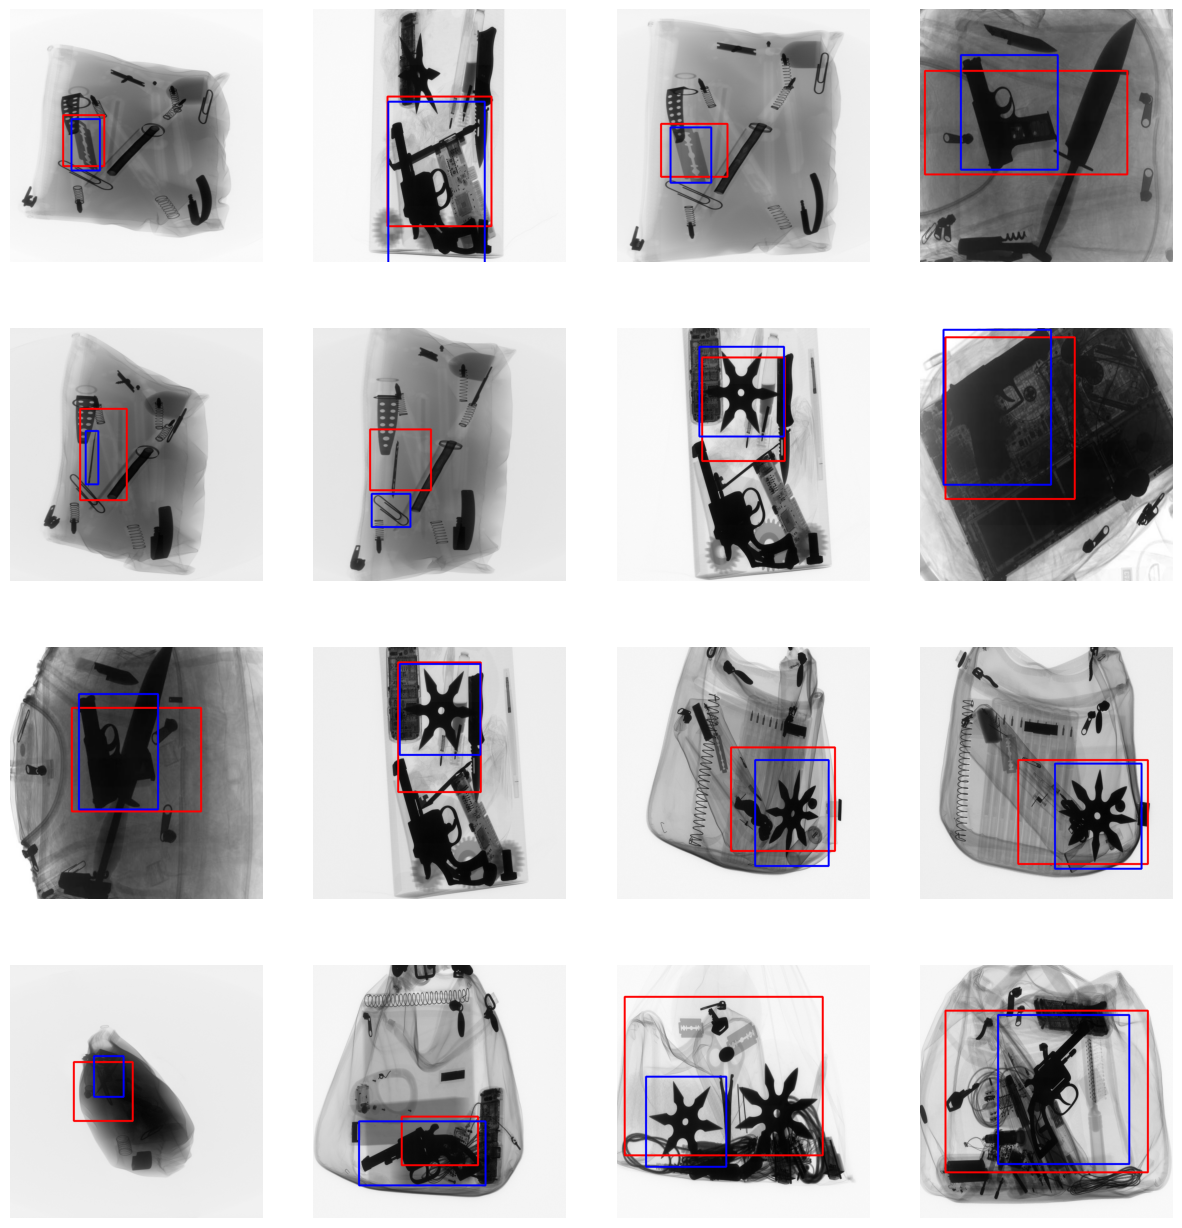

In [12]:
plt.figure(figsize=(15,20))

from_start = random.randint(0, len(test_images) - 16)
to_start = from_start + 16
for i in range(from_start, to_start):
    plt.subplot(5,4,i-from_start+1)
    
    # Make a copy of the image to draw on
    im_to_draw = test_images[i].copy()
    
    # --- Predicted BBox ---
    bbox = predicted_bbox_list[i]
    # Convert bbox coordinates to integers
    pt1 = (int(bbox[0]), int(bbox[1]))
    pt2 = (int(bbox[2]), int(bbox[3]))
    # Draw the predicted bounding box
    cv2.rectangle(im_to_draw, pt1, pt2, (255, 0, 0), 3) # red for predicted

    # --- Ground Truth BBox ---
    gt_bbox = test_bboxes[i]
    gt_pt1 = (int(gt_bbox[0]), int(gt_bbox[1]))
    gt_pt2 = (int(gt_bbox[2]), int(gt_bbox[3]))
    # Draw the ground truth bounding box
    cv2.rectangle(im_to_draw, gt_pt1, gt_pt2, (0, 0, 255), 3) # blue for ground truth
    
    plt.imshow(im_to_draw)
    # plt.title(f'Img {i}: Red=Pred, Blue=GT')
    plt.axis('off') # Hide axes
plt.show()
# plt.savefig('detect/test_results_yolov9.png')

**Testing the agent (last weight) on test images and calculating the average iou:**

last model weights

In [8]:
# This function is largely for visualization and saving, can be adapted similarly to test2
def test(image_list, bounding_box_list):
    iou = []
    predicted_bbox_list = []

    number_of_image = len(image_list)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_model = create_feature_extractor(finetune=False).to(device)
    deep_q = create_q_model().to(device)

    deep_q_checkpoint = torch.load(r"weights_DQN_4layer_yolov9/latest_model.pth", map_location=device)
    deep_q.load_state_dict(deep_q_checkpoint['policy_net_state_dict'])

    yolov9_backbone_path = r'weights\best.pt'
    feature_state_dict = torch.load(yolov9_backbone_path, map_location=device, weights_only=False)
    feature_model.load_state_dict(feature_state_dict, strict=False)

    deep_q.eval()
    feature_model.eval()

    for i in range(0, number_of_image):
        bounding_box = bounding_box_list[i]
        image = image_list[i].copy()
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, feature_model)
        
        end = False
        masks = []
        step = 0

        while not end:
            q_value = compute_q(feature, deep_q)
            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == max_steps:
                end = True
                print(f"Image {i}: End of search.")
                new_mask = current_mask
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, feature_model)
            
            masks.append(new_mask)
            current_mask = new_mask
            step += 1

        mask = masks[-1] if masks else current_mask
        iou.append(compute_iou(mask, bounding_box))
        predicted_bbox_list.append(mask)

    avg_iou = sum(iou) / len(iou)
    pd.DataFrame(iou).to_csv('output_iou_test_data.csv', header=False, index=False)
    
    return avg_iou, predicted_bbox_list

In [9]:
# avg_iou, predicted_bbox_list = test(test_images, test_bboxes)
avg_iou, predicted_bbox_list = test(test_images, test_bboxes)
print(f"Test Average IoU: {avg_iou}")

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Loaded YOLOv9 weights from weights/best.pt
Image 0: End of search.
Image 1: End of search.
Image 2: End of search.
Image 3: End of search.
Image 4: End of search.
Image 5: End of search.
Image 6: End of search.
Image 7: End of search.
Image 8: End of search.
Image 9: End of search.
Image 10: End of search.
Image 11: End of search.
Image 12: End of search.
Image 13: End of search.
Image 14: End of search.
Image 15: End of search.
Image 16: End of search.
Image 17: End of search.
Image 18: End of search.
Image 19: End of search.
Image 20: End of search.
Image 21: End of search.
Image 22: End of search.
Image 23: End of search.
Image 24: End of search.
Image 25: End of search.
Image 26: End of search.
Image 27: End of search.
Image 28: End of search.
Image 29: End of search.
Image 30: End of search.
Image 31: End of search.
Image 32: End of search.
Image 33: End of search.
Image 34: End of search.
Image 35: End of search.
Image 36: End of search.
Image 37: End of search.
Image 38: End of 

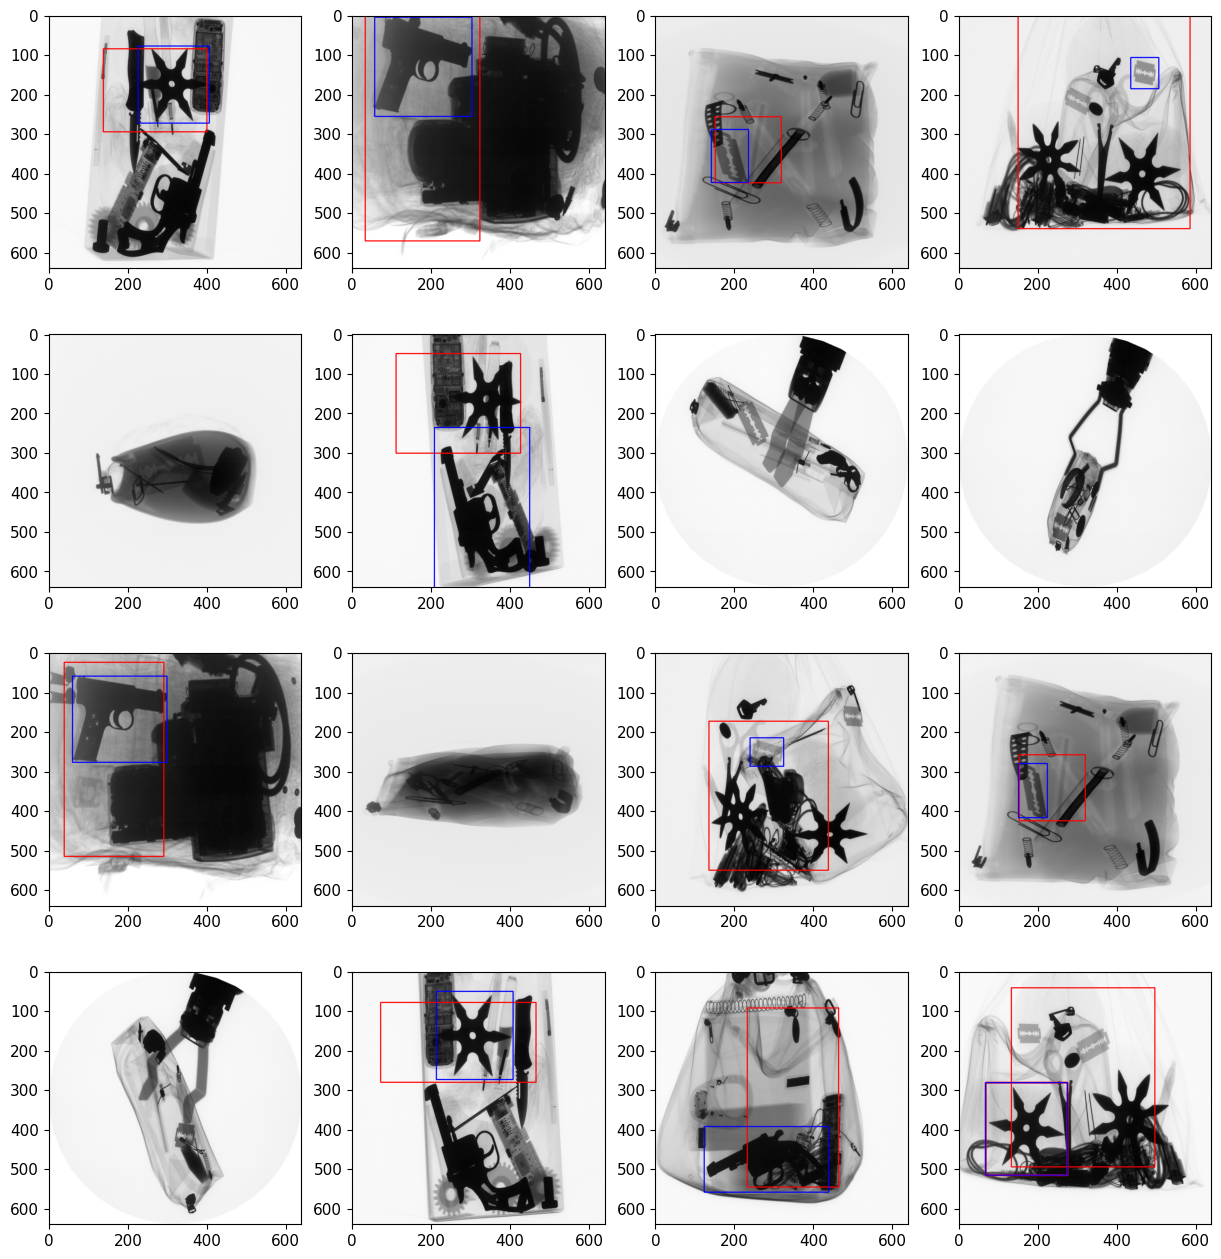

In [49]:
plt.figure(figsize=(15,20))

from_start = random.randint(0, len(test_images) - 16)
to_start = from_start + 16
for i in range(from_start, to_start):
    plt.subplot(5,4,i-from_start+1)\
    
    # Make a copy of the image to draw on
    im_to_draw = test_images[i].copy()
    
    # --- Predicted BBox ---
    bbox = predicted_bbox_list[i]
    # Convert bbox coordinates to integers
    pt1 = (int(bbox[0]), int(bbox[1]))
    pt2 = (int(bbox[2]), int(bbox[3]))
    # Draw the predicted bounding box
    cv2.rectangle(im_to_draw, pt1, pt2, (255, 0, 0), 2) # red for predicted

    # --- Ground Truth BBox ---
    gt_bbox = test_bboxes[i]
    gt_pt1 = (int(gt_bbox[0]), int(gt_bbox[1]))
    gt_pt2 = (int(gt_bbox[2]), int(gt_bbox[3]))
    # Draw the ground truth bounding box
    cv2.rectangle(im_to_draw, gt_pt1, gt_pt2, (0, 0, 255), 2) # blue for ground truth
    
    plt.imshow(im_to_draw)
    # plt.title(f'Img {i}: Red=Pred, Blue=GT')
    # plt.axis('off') # Hide axes
plt.show()
# plt.savefig('detect/test_results_yolov9.png')

Text(0, 0.5, 'Average IoU')

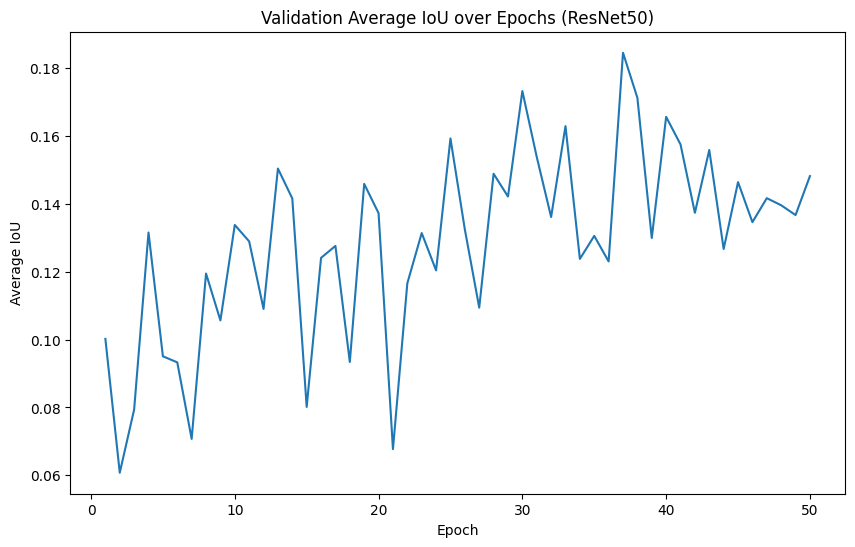

In [ ]:
# validation plot
avg_iou_df = pd.read_csv(r'train_plot_yolov9/avg_iou.csv')
plt.figure(figsize=(10, 6))
plt.plot(avg_iou_df['epoch'], avg_iou_df['avg_iou'])
plt.title('Validation Average IoU over Epochs (YOLOv9)')
plt.xlabel('Epoch')
plt.ylabel('Average IoU')

Text(0, 0.5, 'Loss')

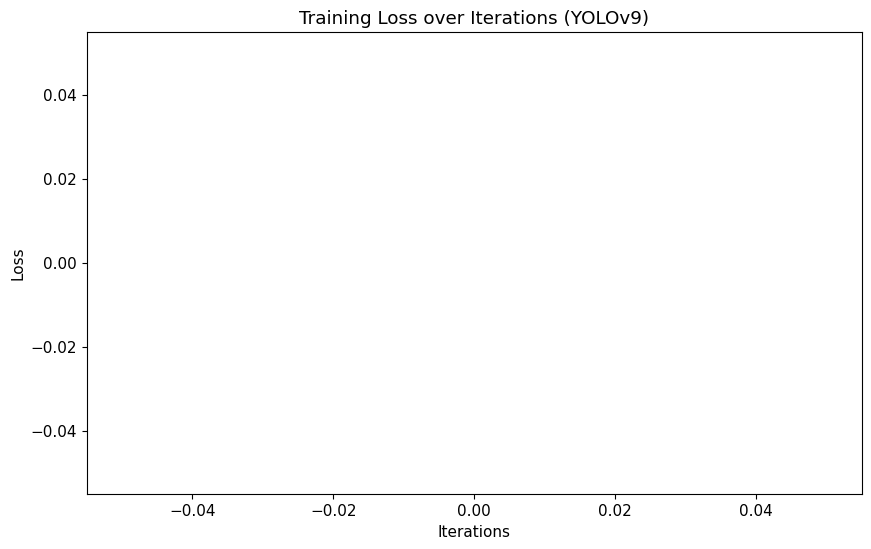

In [9]:
# loss plot
plt.figure(figsize=(10, 6))
plt.plot(loss_arr)
plt.title('Training Loss over Iterations (YOLOv9)')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [31]:
def classify_bbox(image, bbox, threshold=0.5):
    """
    Classify a cropped bounding box using YOLOv9 to check if it contains dangerous objects.
    
    Args:
        image: Original image (numpy array).
        bbox: Bounding box [x_min, y_min, x_max, y_max].
        threshold: Confidence threshold for classification.
    
    Returns:
        bool: True if bbox contains dangerous object (confidence > threshold), False otherwise.
    """
    from yolov9.utils.general import non_max_suppression  # Import here to ensure availability
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load full YOLOv9 model for classification
    config_path = r'yolov9/models/detect/gelan-c.yaml'
    weights_path = r'weights/best.pt'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    full_model = Model(config, ch=3, nc=4)
    ckpt = torch.load(weights_path, map_location=device, weights_only=False)
    full_model.load_state_dict(ckpt["model"].float().state_dict(), strict=False)
    full_model.to(device).eval()
    
    # Crop image by bbox
    cropped = crop_image(image, bbox)
    if cropped.shape[0] == 0 or cropped.shape[1] == 0:
        return False  # Invalid crop
    
    # Preprocess cropped image
    img_rgb = cropped.copy()
    img_letterbox, _, _ = letterbox(img_rgb, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=False)
    img_letterbox = img_letterbox.astype(np.float32) / 255.0
    img_letterbox = np.ascontiguousarray(img_letterbox.transpose(2, 0, 1))
    input_tensor = torch.from_numpy(img_letterbox).unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        pred = full_model(input_tensor)[0]
        pred = non_max_suppression(pred, conf_thres=0.1, iou_thres=0.45)
    
    # Check for dangerous classes (assuming classes 0-3 are dangerous)
    dangerous_classes = [0, 1, 2, 3]
    max_conf = 0.0
    for det in pred[0]:
        if int(det[5]) in dangerous_classes:
            max_conf = max(max_conf, det[4].item())
    
    return max_conf > threshold